In [ ]:
!git clone https://github.com/modusdatascience/choldate.git
!cd choldate; python3 setup.py install 
!pip install p_tqdm
import sys
sys.path.append('/content/choldate')
from choldate import cholupdate, choldowndate
from scipy.linalg import solve_triangular
import scipy
from multiprocessing import Pool, cpu_count
#from p_tqdm import p_map, p_starmap
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats 
from scipy.stats.distributions import chi2
from tqdm.notebook import tqdm
import itertools
import seaborn as sns
import pandas as pd
from scipy.special import softmax
from scipy.special import logsumexp
import time
from itertools import repeat
from functools import partial

fatal: destination path 'choldate' already exists and is not an empty directory.
running install
running build
running build_py
running build_ext
running install_lib
running install_egg_info
Removing /usr/local/lib/python3.8/dist-packages/choldate-0.1.0.egg-info
Writing /usr/local/lib/python3.8/dist-packages/choldate-0.1.0.egg-info
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Library + Library Helpers


In [ ]:
def get_moments(X):
  n, p = X.shape
  mu_hat = np.mean(X, axis=0)
  Sigma_hat = 1/n * (X - mu_hat).T @ (X - mu_hat)
  return mu_hat, Sigma_hat

def complement(n, idxs):
  if len(idxs) == 0:
    return np.arange(n)
  return np.delete(np.arange(n), idxs)

def scale_cov(Sigma, s):
  s = np.sqrt(s)
  return s[None, :] * Sigma * s[:, None]

def standardize_cov(Sigma):
  s = np.diag(Sigma)**(-1)
  return scale_cov(Sigma, s)

def random_argmin(x):
  return np.random.choice(np.flatnonzero(x == x.min()))

def quadratic_form(X, A, Y):
  return np.sum((X @ A) * Y , axis=1)

def diagonal_left_multiply(D, A):
  return D[:, None] * A

def diagonal_right_multiply(A, D):
  return A * D[None, :]

def update_cholesky_after_removing_first(L):
  L_ = L[1:, 1:].copy()
  v = L[1:, 0].copy()
  L_ = L_.T
  cholupdate(L_, v)
  return L_.T

def update_cholesky_after_removing_last(L):
  return L[:L.shape[0] - 1, :L.shape[1] - 1]

def update_cholesky_after_adding_last(L, v):
  p = len(v)
  if p == 1:
    return np.sqrt(np.array([v]))
  a = v[:(p-1)]
  d = v[p-1]
  a_ = solve_triangular(L, a, lower=True) 
  d_ = np.sqrt(d - np.inner(a_, a_))
  L_ = np.zeros((p, p))
  L_[:(p-1), :(p-1)] = L
  L_[p-1, :(p-1)] = a_
  L_[p-1, p-1] = d_
  return L_

def solve_with_cholesky(L, v):
  return solve_triangular(L.T, solve_triangular(L, v, lower=True), lower=False)

In [ ]:
class ColumnSubsetSelection():
  def __init__(self):
    self.colinearity_errors = {}

  def error_check(self, objective, method):

    if not isinstance(self.k, (int, np.integer)) or self.k <= 0 or self.k > self.p:
      raise ValueError("k must be an integer > 0 and <= p.")
    if objective not in {'css'}:
      raise ValueError("Requested objective not supported.")
    if method not in {'greedy', 'swap'}:
      raise ValueError("Requested method not supported.")

  def select_subset_from_data(self, X, k, standardize=False, center=True, objective='css', method='greedy', **kwargs):
    
    objective=objective.lower()
    method=method.lower()
    self.n, self.p = X.shape
    self.k = k
    self.error_check(objective, method)

    self.X = X
    mu = np.mean(self.X, axis = 0)

    if not center and not standardize: 
      Sigma = 1/self.n * self.X.T @ self.X
    if center and not standardize:
      self.X -= mu
      Sigma = 1/n * self.X.T @ self.X 
    if standardize and not center:
      Sigma = 1/n * (self.X -  mu).T (self.X -  mu)
      self.X = diagonal_left_multiply(self.X - mu, 1/np.sqrt(np.diag(Sigma))) + mu
      Sigma = 1/n * self.X.T @ self.X
    if standardize and center:
      self.X -= mu
      self.X = diagonal_left_multiply(self.X, 1/np.sqrt(np.diag(Sigma)))
      Sigma = 1/n * self.X.T @ self.X 
    
    self.select_subset_from_cov(Sigma, k, standardize=False, objective=objective, method=method, from_data=True, **kwargs)

  def select_subset_from_cov(self, Sigma, k, standardize=False, objective='css', method='greedy', **kwargs):

    from_data = kwargs.get('from_data', False)
    full_rank = kwargs.get('full_rank', False)

    self.tol = kwargs.get('tol', 10e-12)

    if not from_data:
      if Sigma.shape[0] != Sigma.shape[1]:
        raise ValueError("Sigma must be a square matrix.")
      self.k = k
      self.p = Sigma.shape[0]
      objective=objective.lower()
      method=method.lower()
      self.error_check(objective, method)

    if standardize:
      Sigma = standardize_cov(Sigma)
    
    self.Sigma = Sigma
    self.p = Sigma.shape[0]
    self.k = k

    max_iter = kwargs.get('max_iter', 100)
    S_init = kwargs.get('S_init', None)

    if objective == 'css':
      objective_func = self._CSS_objective_func
    if objective == 'pcss':
      objective_func = self._PCSS_objective_func
    if objective == 'fss':
      objective_func = self._FSS_objective_func

    if method == 'greedy':
      self._greedy_subset_selection(objective_func, full_rank=full_rank)
    if method == 'swap':
      self._swapping_subset_selection(objective_func, S_init=S_init, max_iter=max_iter, full_rank=full_rank)

  def _swap(self, Sigma, idxs1, idxs2, idx_order=None, disjoint=False, row=True, col=True):
    if not disjoint:
      idxs1, idxs2 = set(idxs1), set(idxs2)
      idxs1, idxs2 = list(idxs1 - idxs2) , list(idxs2 - idxs1)
    if len(idxs1) == 0:
      return
    self._perm(Sigma, np.concatenate([idxs1, idxs2]), np.concatenate([idxs2, idxs1]), idx_order=idx_order, row=True, col=True)
  
  def _perm(self, Sigma, idxs_to_apply, perm, idx_order=None, row=True, col=True):
    if col:
      Sigma[:, idxs_to_apply] = Sigma[:, perm]
    if row:
      Sigma[idxs_to_apply, :] = Sigma[perm, :]
    if idx_order is not None:
      idx_order[idxs_to_apply] = idx_order[perm]

  def _is_invertible(self, Sigma_S):
    try:
      Sigma_S_L = np.linalg.cholesky(Sigma_S)
    except:
      return False, None
    if self.k == 1 and Sigma_S[0, 0] > self.tol:
      return True, Sigma_S_L
    idxs = np.arange(self.k)
    perm_idxs = np.concatenate([np.arange(1, self.k), [0]])
    for i in range(self.k):
      Sigma_T_L = update_cholesky_after_removing_first(Sigma_S_L)
      v = Sigma_S[1:self.k, 0]
      if Sigma_S[0, 0] - v.T @ solve_with_cholesky(Sigma_T_L, v) < self.tol:
        return False, None
      self._perm(Sigma_S, idxs, perm_idxs) 
      Sigma_S_L = update_cholesky_after_adding_last(Sigma_T_L, Sigma_S[self.k-1, :])
    return True, Sigma_S_L
  
  def _regress_one_off(self, Sigma, j):
    Sigma[:, :] = Sigma - np.outer(Sigma[:, j], Sigma[:, j])/Sigma[j, j]    
  
  def _regress_off(self, Sigma, S):
    for j in S:
      self._regress_one_off(Sigma, j)

  def _CSS_objective_func(self, Sigma_R):
    return -1 * np.sum(np.square(Sigma_R), axis=1)/np.diag(Sigma_R)

  def _colinearity_objective_func(self, Sigma_R):
    return np.diag(Sigma_R)

  def _greedy_subset_selection(self, objective_func, full_rank=False):
    
    self.terminated_early=False
    
    self.S_ordered = -1 * np.ones(self.k).astype(int)
    Sigma_R = self.Sigma.copy()
    self._idx_order = np.arange(self.p)
    num_active=self.p

    Sigma_S_L = np.array([[]])

    for i in range(self.k):
      Sigma_R_active = Sigma_R[:num_active, :num_active]
      self._S_in = self.S_ordered[:i]
      objectives = objective_func(Sigma_R_active)
      j_star = random_argmin(objectives)
      S_new = self._idx_order[j_star]
      self.S_ordered[i] = S_new
      Sigma_S_L = update_cholesky_after_adding_last(Sigma_S_L, self.Sigma[S_new, self.S_ordered[:(i+1)]])
      self._regress_one_off(Sigma_R_active, j_star)
      self._swap(Sigma_R, [j_star], [self.p - i - 1], idx_order=self._idx_order)
      num_active -= 1
      
      if not full_rank:
        zero_idxs = np.where(np.diag(Sigma_R_active)[:num_active] < self.tol)[0]
        num_zero_idxs = len(zero_idxs)
        idxs_to_swap = np.arange(num_active - num_zero_idxs, num_active)
        self._swap(Sigma_R, zero_idxs, idxs_to_swap, idx_order=self._idx_order)
        num_active -= num_zero_idxs
      
      if num_active == 0 and i != self.k - 1:
        self.terminated_early = True
        print('Terminating early: ' + str(self.S_ordered[:(i+1)]) + ' are sufficient to explain the remaining')
        break

    self._perm(Sigma_R, np.arange(self.p), np.argsort(self._idx_order))
    self.Sigma_R = Sigma_R
    self.S = set(self.S_ordered)
    #self._Sigma_S_inv = solve_with_cholesky(Sigma_S_L, np.eye(self.k)) 
    #self._perm(self._Sigma_S_inv, np.arange(self.k), np.argsort(self.S_ordered)) 


  def _swapping_subset_selection(self, objective_func, S_init=None, max_iter=100, full_rank=False):

    self.converged = False
    d = self.p - self.k
    self._idx_order = np.arange(self.p)
    
    if S_init is None:
      S_init = np.random.choice(self._idx_order, self.k, replace=False)
    elif len(S_init) != self.k:
      raise ValueError("Initial subset must be of length k.")
    
    self.S_init = np.array(list(S_init))
    Sigma_R = self.Sigma.copy()
    self._swap(Sigma_R, np.arange(d, self.p), self.S_init, idx_order=self._idx_order)
    S = self._idx_order[d:].copy()
    Sigma_S = self.Sigma[:, S][S, :].copy()
    invertible, Sigma_S_L = self._is_invertible(Sigma_S) 
    
    if not invertible:
      self.colinearity_errors[frozenset(S)] = None
      raise ValueError("Colinearity issue: covariance of initial selected subset is not full rank.")
    
    self._regress_off(Sigma_R, np.arange(d, self.p))
    zero_idxs = np.where(np.diag(Sigma_R)[:d] <= self.tol)[0]
    num_zero_idxs = len(zero_idxs)
    
    if full_rank and num_zero_idxs > 0:
      self.colinearity_errors[frozenset(S)] = frozenset(self._idx_order[zero_idxs])
      raise ValueError("Colinearity issue: the initial subset perfectly predicts some other features")

    N = 0
    not_replaced = 0
    subset_idxs = np.arange(d, self.p)
    subset_idxs_permuted = np.concatenate([subset_idxs[1:], np.array([subset_idxs[0]])])
    break_flag = False 

    while N < max_iter and (not break_flag):
      for i in range(self.k):
        S_0 = S[0]
        T = S[1:]
      
        Sigma_T_L = update_cholesky_after_removing_first(Sigma_S_L) 
        v = self.Sigma[:, S_0] - self.Sigma[:, T] @ solve_with_cholesky(Sigma_T_L, self.Sigma[T, S_0]) if self.k > 1 else self.Sigma[:, S_0]
        reordered_v = v[self._idx_order]

        Sigma_R = Sigma_R + np.outer(reordered_v, reordered_v)/v[S_0]
        self._swap(Sigma_R, np.array([0]), np.array([d]), idx_order=self._idx_order)  
            
        if not full_rank:
          zero_idxs = np.where(np.diag(Sigma_R)[:(d + 1)] <= self.tol)[0]
          num_zero_idxs = len(zero_idxs)
          self._swap(Sigma_R, zero_idxs, np.arange(d + 1 - num_zero_idxs, d + 1), idx_order=self._idx_order)
        else:
          num_zero_idxs = 0 
        num_active = d + 1 - num_zero_idxs 
        self._S_in = T
        objectives = objective_func(Sigma_R[:num_active, :num_active])
        choices = np.flatnonzero(objectives == objectives.min())

        if 0 in choices:
          not_replaced += 1
          j_star = 0 
        else:
          not_replaced = 0
          j_star = np.random.choice(choices)

        S_new = self._idx_order[j_star]
        S[:self.k-1] = S[1:]
        S[self.k-1] = S_new
        Sigma_S_L = update_cholesky_after_adding_last(Sigma_T_L, self.Sigma[S_new, S])
        self._regress_one_off(Sigma_R[:(d+1), :(d+1)], j_star) 
        self._swap(Sigma_R, np.array([j_star]), np.array([d]), idx_order=self._idx_order)
        self._perm(Sigma_R, subset_idxs,  subset_idxs_permuted, idx_order=self._idx_order)
        if not_replaced == self.k:
          self.converged=True
          break_flag=True
          break
      N += 1

    self._perm(Sigma_R, np.arange(self.p), np.argsort(self._idx_order))
    self.Sigma_R = Sigma_R
    self.S = set(S.astype(int))
    #self._Sigma_S_inv = solve_with_cholesky(Sigma_S_L, np.eye(self.k))
    #self._perm(self._Sigma_S_inv, np.arange(self.k), np.argsort(S))




    
    
    

In [ ]:
#@title
class MLColumnSubsetSelection(ColumnSubsetSelection):
  def __init__(self):
    super().__init__()
    self.colinearity_errors = {}
    self._model_to_objective = {'pcss' : 'pcss', 'sf': 'fss' }

  def error_check(self, objective, method, model=None):
    
    if model is not None and model not in {'pcss', 'sf'}:
      raise ValueError("Requested model not supported.")
    if not isinstance(self.k, (int, np.integer)) or self.k <= 0 or self.k > self.p:
      raise ValueError("k must be an integer > 0 and <= p.")
    if objective not in {'pcss', 'fss'}:
      raise ValueError("Requested objective not supported.")
    if method not in {'greedy', 'swap'}:
      raise ValueError("Requested method not supported.")
  
  def _populate_colinearity(self, resids):
    for i in range(resids.shape[0]):
      where = np.where(resids[i, :] <= self.tol)[0]
      if len(where) == 0:
        continue
      current_selected = np.concatenate([self._S_in, np.array([self._idx_order[i]])])
      self.colinearity_errors[frozenset(current_selected)] = frozenset(self._idx_order[where])
  
  def _PCSS_objective_func(self, Sigma_R):
    diag = np.diag(Sigma_R)
    resids = diag - diagonal_left_multiply(1/diag, np.square(Sigma_R))
    np.fill_diagonal(resids, 1)
    if np.any(resids <= self.tol):
      self._populate_colinearity(resids)
      raise ValueError('Issues with colinearity.')  
    np.fill_diagonal(resids, 0)
    objective_values = np.log(diag) + (Sigma_R.shape[0] - 1) * np.log(np.sum(resids, axis=1))
    return objective_values
  
  def _FSS_objective_func(self, Sigma_R):
    diag = np.diag(Sigma_R)
    resids = diag - diagonal_left_multiply(1/diag, np.square(Sigma_R))
    np.fill_diagonal(resids, 1)
    if np.any(resids <= self.tol):
      self._populate_colinearity(resids)
      raise ValueError('Issues with colinearity.') 
    log_resids = np.log(resids)
    objective_values = np.log(diag) + np.sum(log_resids, axis=1)
    return objective_values

  def compute_MLE_from_data(self, X, k, model='pcss', method='greedy', **kwargs):
    method=method.lower()
    model=model.lower()
    self.n, self.p = X.shape
    self.missing_data = False
    self.k = k
    self.error_check(self._model_to_objective[model], method, model)

    self.X = X

    mu_MLE, Sigma_hat = get_moments(X)
    self.compute_MLE_from_cov(Sigma_hat, self.k, model=model, method=method, from_data=True, mu_MLE=mu_MLE, **kwargs)


  def compute_MLE_from_cov(self, Sigma, k, model='pcss', method='greedy', **kwargs):
    from_data = kwargs.get('from_data', False)

    if not from_data:
      if Sigma.shape[0] != Sigma.shape[1]:
        raise ValueError("Sigma must be a square matrix.")
      self.k = k
      self.p = Sigma.shape[0]
      self.missing_data = False
      method=method.lower()
      model=model.lower()
      self.error_check(self._model_to_objective[model], method, model)

    mu_MLE = kwargs.get('mu_MLE', None)
    self.select_subset_from_cov(Sigma, k, objective=self._model_to_objective[model], method=method, full_rank=True, **kwargs)
    self._compute_MLE_from_selected_subset(model, mu_MLE)

  def _compute_MLE_from_selected_subset(self, model, mu_MLE=None):

    self._S = np.sort(list(self.S))
    self._S_comp = complement(self.p, self._S)

    try:
      self._X_S = self.X[:, self._S]
      self._X_S_comp = self.X[:, self._S_comp]
    except:
      pass

    Sigma_S_comp_S = self.Sigma[self._S_comp, :][:, self._S]
    S_MLE = self.S 
    C_MLE = self.Sigma[:, self._S][self._S, :]
    self._Sigma_S_L = np.linalg.cholesky(C_MLE)
    Sigma_S_inv = solve_with_cholesky(self._Sigma_S_L, np.eye(self.k))
    Sigma_S_L_diag = np.diag(self._Sigma_S_L)
    W_MLE = Sigma_S_comp_S @ Sigma_S_inv

    if model == 'pcss':
      sigma_sq_MLE = np.sum(np.diag(self.Sigma_R)[self._S_comp]) /(self.p - self.k)
      D_MLE = sigma_sq_MLE*np.ones(self.p - self.k)
    elif model == 'sf':
      D_MLE = np.diag(self.Sigma_R)[self._S_comp]

    self._log_det_Sigma_MLE = np.sum(np.log(np.square(Sigma_S_L_diag))) + np.sum(np.log(D_MLE)) 
    
    # contains Sigma^{-1}_{SS}, Sigma^{-1}_{S, -S}, Sigma^{-1}_{-S, -S} where both S and -S are sorted 
    D_MLE_inv = 1/D_MLE
    temp = diagonal_right_multiply(W_MLE.T, D_MLE_inv)
    self._Sigma_MLE_inv = (Sigma_S_inv + temp  @ W_MLE, -1*temp, D_MLE_inv)
    
    if model == 'pcss':
      self.MLE = {'mu_MLE': mu_MLE,
                  'S_MLE': S_MLE,
                  'C_MLE': C_MLE,
                  'W_MLE': W_MLE,
                  'sigma_sq_MLE': sigma_sq_MLE}
    elif model == 'sf':
      self.MLE = {'mu_MLE': mu_MLE,
                  'S_MLE': S_MLE,
                  'C_MLE': C_MLE,
                  'W_MLE': W_MLE,
                  'D_MLE': D_MLE}

    if self.missing_data:   
      self._D_MLE = D_MLE
      # Full MLE covariance, with order S and then S_comp both sorted
      order_perm = np.concatenate([self._S, self._S_comp])
      self._unorder_perm = np.argsort(order_perm)
      self._mu_MLE_ordered = self.MLE["mu_MLE"][order_perm]
      self._Sigma_MLE_ordered = np.zeros((self.p, self.p))
      self._Sigma_MLE_ordered[:self.k, :self.k] = C_MLE.copy()
      self._Sigma_MLE_ordered[:self.k, self.k:] = Sigma_S_comp_S.T
      self._Sigma_MLE_ordered[self.k:, :self.k] = Sigma_S_comp_S
      self._Sigma_MLE_ordered[self.k:, self.k:] = Sigma_S_comp_S @ Sigma_S_inv @ Sigma_S_comp_S.T
      np.fill_diagonal(self._Sigma_MLE_ordered[self.k:, self.k:], np.diag(self._Sigma_MLE_ordered[self.k:, self.k:]) + D_MLE)


  def _get_cholesky(self, C_MLE, W_MLE, D_MLE):
    Sigma_S_L = np.linalg.cholesky(C_MLE)
    Sigma_MLE_chol = np.zeros((self.p, self.p))
    Sigma_MLE_chol[:self.k, :self.k] = Sigma_S_L
    Sigma_MLE_chol[self.k: , :self.k] = W_MLE @ Sigma_S_L 
    np.fill_diagonal(Sigma_MLE_chol, np.concatenate([np.diag(Sigma_S_L), np.sqrt(D_MLE)]))
    return Sigma_MLE_chol
  
  def _perm_3d(self, tensor, idxs_to_apply, perm, idx_order=None, row=True, col=True): 
    if col:
      tensor[:, :, idxs_to_apply] = tensor[:, :, perm]
    if row:
      tensor[:, idxs_to_apply, :] = tensor[:, perm, :]
    if idx_order is not None:
      idx_order[idxs_to_apply] = idx_order[perm]

  
  def _compute_imputed_moments(self):

    Omega = np.zeros((self.n, self.p, self.p))
    m = np.zeros((self.n, self.p))

    for i in range(self.n):

      x_S = self._X_S[i, :]
      x_S_comp = self._X_S_comp[i, :]
      x = np.concatenate([x_S, x_S_comp])

      subset_missing = np.where(np.isnan(x_S))[0]
      subset_not_missing = np.where(~np.isnan(x_S))[0]
      num_subset_missing = len(subset_missing)
      
      other_missing = np.where(np.isnan(x_S_comp))[0] + self.k 
      other_not_missing = np.where(~np.isnan(x_S_comp))[0] + self.k
      num_other_missing = len(other_missing)
      
      missing = np.concatenate([subset_missing, other_missing])
      not_missing = complement(self.p, missing)
      num_not_missing = len(not_missing)
      num_missing = len(missing)

      x_not_missing = x[not_missing]
      if len(subset_missing) == 0:

        other_missing_adjusted = missing - self.k
        m_missing = self.MLE['W_MLE'][other_missing_adjusted, :] @ (x_S - self._mu_MLE_ordered[:self.k]) + self._mu_MLE_ordered[missing]
        Omega_missing = np.outer(m_missing, m_missing)
        np.fill_diagonal(Omega_missing, np.diag(Omega_missing) + self._D_MLE[other_missing_adjusted])

      else:
        Sigma_perm = np.concatenate([not_missing, missing])
        self._perm(self._Sigma_MLE_ordered, np.arange(self.p), Sigma_perm)
 
        subset_perm = np.concatenate([subset_missing, subset_not_missing])
        other_perm = np.concatenate([other_not_missing, other_missing]) - self.k

        C_MLE = self.MLE['C_MLE'].copy()
        W_MLE = self.MLE['W_MLE'].copy()
        self._perm(C_MLE, np.arange(self.k), subset_perm)
        self._perm(W_MLE, np.arange(self.k), subset_perm, row=False)
        self._perm(W_MLE, np.arange(self.p-self.k), other_perm, col=False)
        D_MLE = self._D_MLE.copy()[other_perm] 

        Sigma_MLE_chol = self._get_cholesky(C_MLE, W_MLE, D_MLE)
        Sigma_MLE_chol = Sigma_MLE_chol[:(self.p - num_other_missing), :(self.p - num_other_missing)]
        for _ in range(num_subset_missing):
          Sigma_MLE_chol = update_cholesky_after_removing_first(Sigma_MLE_chol)
        Sigma_MLE_not_missing_inv = solve_with_cholesky(Sigma_MLE_chol, np.eye(num_not_missing))
  
        Sigma_MLE_missing_not_missing = self._Sigma_MLE_ordered[self.p-num_missing:self.p , :num_not_missing]
        temp =  Sigma_MLE_missing_not_missing @ Sigma_MLE_not_missing_inv
        m_missing = temp @ (x_not_missing - self._mu_MLE_ordered[not_missing]) + self._mu_MLE_ordered[missing] 
        Omega_missing = self._Sigma_MLE_ordered[num_not_missing:, num_not_missing:] -  temp @ Sigma_MLE_missing_not_missing.T + np.outer(m_missing, m_missing)
         
        self._perm(self._Sigma_MLE_ordered, np.arange(self.p), np.argsort(Sigma_perm))

      m[i, missing] = m_missing
      m[i, not_missing] = x_not_missing

      Omega[i, :num_not_missing, :num_not_missing] = np.outer(x_not_missing, x_not_missing)
      Omega[i, num_not_missing:, :num_not_missing] = np.outer(m_missing, x_not_missing)
      Omega[i, :num_not_missing, num_not_missing:] = Omega[i, num_not_missing:, :num_not_missing].T
      Omega[i, num_not_missing:, num_not_missing:] = Omega_missing

      Omega_perm = np.zeros(self.p).astype(int)
      Omega_perm[missing] = np.arange(num_not_missing, self.p)
      Omega_perm[not_missing] = np.arange(num_not_missing)
      self._perm(Omega[i, :, :], np.arange(self.p), Omega_perm)


    self._perm(m, np.arange(self.p), self._unorder_perm, row=False)
    self._perm_3d(Omega, np.arange(self.p), self._unorder_perm)

    return np.mean(m, axis=0), np.mean(Omega, axis=0)


  def compute_MLE_from_partially_observed_data(self, X, k, model='pcss', **kwargs):

    model=model.lower()
    tau = kwargs.get('tau', 10e-6)

    self.n, self.p = X.shape
    self.k = k 
    self.error_check(self._model_to_objective[model], 'swap', model)

    self.missing_data = True
    self.tau = tau 
    
    self.coverged_EM = False
    self.log_likelihood_history = []

    self.X = X
    
    S_init = kwargs.get("S_init", None)
    tau = kwargs.get("tau", 10e-6)
    max_em_iter = kwargs.get("max_em_iter", 100)
    max_iter = kwargs.get("max_iter", 100)
    check_every = kwargs.get("check_every", 10)

    X_init = np.where(np.isnan(X), np.nanmean(X, axis=0), X)  
    mu_init, Sigma_init = get_moments(X_init)

    if S_init is None:
      S_init = np.random.choice(np.arange(self.p), self.k, replace=False)
    elif len(S_init) != self.k:
      raise ValueError("Initial subset must be of length k.")

    self.S_init_EM = S_init

    self.compute_MLE_from_cov(Sigma_init, 
                              self.k, 
                              model=model, 
                              method='swap', 
                              S_init=S_init,
                              max_iter=0,
                              from_data=True, 
                              mu_MLE=mu_init)
 
    #prev_S_init = None
    #curr_S_init = set(S_init)
    iter = 0
    prev_log_likelihood = -np.inf
    curr_log_likelihood = self.compute_log_likelihood_from_partially_observed_data(reduce_mean=True)
    self.log_likelihood_history.append((iter, curr_log_likelihood))

    #print(self._S)
    while iter < max_em_iter:
      
      m, Omega = self._compute_imputed_moments()
      Psi = Omega - np.outer(m, m)
      self.compute_MLE_from_cov(Psi, 
                                self.k, 
                                model=model, 
                                method='swap',
                                S_init=self._S, 
                                from_data=True,  
                                max_iter=max_iter, 
                                mu_MLE=m)
      #print(self._S)
      #prev_S_init = curr_S_init
      #curr_S_init = self.S
      #print(prev_S_init, curr_S_init)
      #if prev_S_init == curr_S_init and iter > 0:
      #  self.converged=True
      #  break
      iter += 1
      if iter % check_every == 0:
        prev_log_likelihood = curr_log_likelihood
        curr_log_likelihood = self.compute_log_likelihood_from_partially_observed_data(reduce_mean=True)
        self.log_likelihood_history.append((iter, curr_log_likelihood))
        if np.abs(curr_log_likelihood - prev_log_likelihood) < self.tau:
          self.converged_EM=True
          break
      
  
  def compute_log_likelihood(self, X=None, reduce_mean=False):
    if X is None:
      if reduce_mean:
        return -1/2*(self.p * np.log(2 * np.pi) + self.p + self._log_det_Sigma_MLE)
      else:
        try:
          X_S = self._X_S.copy()
          X_S_comp = self._X_S_comp.copy()
        except:
          raise ValueError("X not provided and no default value available")
    else:
      X_S = X[:, self._S]
      X_S_comp = X[:, self._S_comp]
    
    X_S -= self.MLE['mu_MLE'][self._S]
    X_S_comp -= self.MLE['mu_MLE'][self._S_comp]
    log_likelihoods = -1/2*(self.p * np.log(2 * np.pi) +  
                            self._log_det_Sigma_MLE + 
                            quadratic_form(X_S, self._Sigma_MLE_inv[0], X_S) + 
                            2*quadratic_form(X_S, self._Sigma_MLE_inv[1], X_S_comp) +
                            np.sum( diagonal_right_multiply(X_S_comp, self._Sigma_MLE_inv[2]) * X_S_comp, axis = 1) )
    if reduce_mean:
      return np.mean(log_likelihoods)
    else:
      return log_likelihoods 
  
  ### This and with impute moments function need decomposition

  def compute_log_likelihood_from_partially_observed_data(self, X=None, reduce_mean=False):
    if X is None:
      try:
        X_S = self._X_S.copy()
        X_S_comp = self._X_S_comp.copy()
      except:
        raise ValueError("X not provided and no default value available")
    else:
      X_S = X[:, self._S]
      X_S_comp = X[:, self._S_comp]

    n = X_S.shape[0]
    log_likelihoods = np.zeros(n)
    for i in range(n):
      x_S = X_S[i, :]
      x_S_comp = X_S_comp[i, :]
      
      subset_missing = np.where(np.isnan(x_S))[0]
      subset_not_missing = np.where(~np.isnan(x_S))[0]
      num_subset_missing = len(subset_missing)
      
      other_missing_adjusted = np.where(np.isnan(x_S_comp))[0] 
      other_missing = other_missing_adjusted + self.k 
      other_not_missing_adjusted = np.where(~np.isnan(x_S_comp))[0] 
      other_not_missing = other_not_missing_adjusted + self.k
      num_other_missing = len(other_missing)
      
      missing = np.concatenate([subset_missing, other_missing])
      not_missing = complement(self.p, missing)
      num_not_missing = len(not_missing)
      num_missing = len(missing)

      x_S_not_missing = x_S[subset_not_missing]
      x_S_not_missing_centered = x_S_not_missing - self._mu_MLE_ordered[subset_not_missing]
      x_S_comp_not_missing = x_S_comp[other_not_missing_adjusted] 
      x_S_comp_not_missing_centered = x_S_comp_not_missing - self._mu_MLE_ordered[other_not_missing]

      if num_subset_missing == 0:
        W_MLE_missing = self.MLE["W_MLE"][other_missing_adjusted]
        D_MLE_missing = self.MLE["D_MLE"][other_missing_adjusted]
        Sigma_MLE_inv_0 = self._Sigma_MLE_inv[0] - diagonal_right_multiply(W_MLE_missing.T, 1/D_MLE_missing) @ W_MLE_missing
        Sigma_MLE_inv_1 = self._Sigma_MLE_inv[1][:, other_not_missing_adjusted]
        Sigma_MLE_inv_2 = self._Sigma_MLE_inv[2][other_not_missing_adjusted]
        
        log_det_Sigma_MLE = self._log_det_Sigma_MLE - np.sum(np.log(D_MLE_missing))
        log_likelihoods[i] = -1/2*(num_not_missing * np.log(2 * np.pi) + log_det_Sigma_MLE + 
                            x_S_not_missing_centered.T @ Sigma_MLE_inv_0 @ x_S_not_missing_centered + 
                            2* x_S_not_missing_centered.T @ Sigma_MLE_inv_1 @ x_S_comp_not_missing_centered +
                            np.sum(np.square(x_S_comp_not_missing_centered) * Sigma_MLE_inv_2))
      else:
        x_not_missing_centered = np.concatenate([x_S_not_missing_centered, x_S_comp_not_missing_centered])

        Sigma_perm = np.concatenate([not_missing, missing])
        self._perm(self._Sigma_MLE_ordered, np.arange(self.p), Sigma_perm)
 
        subset_perm = np.concatenate([subset_missing, subset_not_missing])
        other_perm = np.concatenate([other_not_missing_adjusted, other_missing_adjusted])

        C_MLE = self.MLE['C_MLE'].copy()
        W_MLE = self.MLE['W_MLE'].copy()
        self._perm(C_MLE, np.arange(self.k), subset_perm)
        self._perm(W_MLE, np.arange(self.k), subset_perm, row=False)
        self._perm(W_MLE, np.arange(self.p-self.k), other_perm, col=False)
        D_MLE = self._D_MLE.copy()[other_perm] 

        Sigma_MLE_chol = self._get_cholesky(C_MLE, W_MLE, D_MLE)
        Sigma_MLE_chol = Sigma_MLE_chol[:(self.p - num_other_missing), :(self.p - num_other_missing)]
        for _ in range(num_subset_missing):
          Sigma_MLE_chol = update_cholesky_after_removing_first(Sigma_MLE_chol)
        
        log_det_Sigma_MLE = np.sum(np.log(np.square(np.diag(Sigma_MLE_chol))))
        Sigma_MLE_not_missing_inv = solve_with_cholesky(Sigma_MLE_chol, np.eye(num_not_missing))
        
        self._perm(self._Sigma_MLE_ordered, np.arange(self.p), np.argsort(Sigma_perm))

        log_likelihoods[i] = -1/2*(num_not_missing * np.log(2 * np.pi) + log_det_Sigma_MLE +  x_not_missing_centered.T @ Sigma_MLE_not_missing_inv @ x_not_missing_centered)

    if reduce_mean:
      return np.mean(log_likelihoods)
    else:
      return log_likelihoods 
   

In [ ]:
#@title

p = 20
k = 5
model='sf'

C_sqrt, W, D = randomly_generate_MLCSS_params(p, k, model, 10, standardize=True)
n = 30000
X = generate_MLCSS_data(n, C_sqrt, W, D, S=None)
q = 0.8
mask = np.random.binomial(1, q, X.shape)
X_partially_observed = X.copy()


for i in range(mask.shape[0]):
  for j in range(mask.shape[1]):
    if mask[i, j] == 0:
      X_partially_observed[i, j] = np.nan
#model='sf'
#S = np.arange(2)
#S_comp = complement(p, S)
#X = np.random.normal(0, 1, (n, p))
#mu_MLE, Sigma = get_moments(X)
#Sigma_MLE = compute_Sigma_MLE(Sigma, np.arange(2), model=model)
#W_MLE = Sigma[S_comp, :][:, S] @ np.linalg.inv(Sigma[S, :][:, S])
#D_MLE = np.diag(Sigma[S_comp, :][:, S_comp] - Sigma[S_comp, :][:, S] @ np.linalg.inv(Sigma[S, :][:, S]) @  Sigma[S, :][:, S_comp])
#C_MLE = Sigma[S, :][:, S]


In [ ]:
#@title
X_init = np.where(np.isnan(X_partially_observed), np.nanmean(X_partially_observed, axis=0), X_partially_observed) 
MLCSS = MLColumnSubsetSelection()
MLCSS.compute_MLE_from_data(X_init, k, model='sf', method='swap')
print(MLCSS.S_init)
print(MLCSS.S)
print(np.mean(np.square(MLCSS.MLE['W_MLE'] - W)))

In [ ]:
#@title
MLCSS = MLColumnSubsetSelection()
MLCSS.compute_MLE_from_partially_observed_data(X_partially_observed, k, model='sf', check_every=10, max_em_iter=100, tau=10e-2, max_iter=0, S_init=np.arange(k))
print(np.mean(np.square(MLCSS.MLE['W_MLE'] - W)))

In [ ]:
#@title
MLCSS = MLColumnSubsetSelection()
MLCSS.compute_MLE_from_partially_observed_data(X_partially_observed, k, model='sf', check_every=10, max_em_iter=100, tau=10e-2)
print(MLCSS.converged_EM)
print(MLCSS.S_init_EM)
print(MLCSS.S)
plt.plot(*zip(*MLCSS.log_likelihood_history))
#print(np.mean(np.square(MLCSS.MLE['W_MLE'] - W)))

In [ ]:
#@title
class MMLColumnSubsetSelection(ColumnSubsetSelection):
  def __init__(self):
    pass 
  
  def _compute_and_stash_scaled_log_likelihoods(self):
    log_likelihoods = np.zeros((self.n , self.C))
    for i in range(self.C):
      log_likelihoods[:, i] = self.models[i].compute_log_likelihood(self.X)
    self._scaled_log_likelihoods = log_likelihoods + self._log_pi

  def _compute_scaled_log_likelihoods(self, X):
    n = X.shape[0]
    log_likelihoods = np.zeros((n, self.C))
    for i in range(self.C):
      log_likelihoods[:, i] = self.models[i].compute_log_likelihood(X)
    return log_likelihoods + self._log_pi

  def compute_posterior_class_probs(self, X=None):
    if X is None:
      ps = softmax(self._scaled_log_likelihoods, axis=1)
    else:
      scaled_log_likelihoods = self._compute_scaled_log_likelihoods(X)
      ps = softmax(scaled_log_likelihoods, axis=1)
    return ps
      
  
  def compute_mixture_MLE_from_data(self, X, C, k, model='pcss', **kwargs):
    
    S_init = kwargs.get('S_init', None)
    pi_init = kwargs.get('pi_init', None)
    max_iter = kwargs.get('max_iter', 1000)
    max_swaps = kwargs.get('max_swaps', 1000)
    tol = kwargs.get('tol', 10e-12)
    check_every = kwargs.get('check_every', 50)
    tau = 10e-6

    self.converged=False 
    self.log_likelihood_history = []

    n, p = X.shape

    self.X = X
    self.C = C
    self.n = n
    self.p = p 
    self.ks = k
    self.tau = tau

    if not isinstance(C, (int, np.integer)) or C <= 0:
      raise ValueError("C must be a positive integer")
    
    if S_init is not None:
      if len(S_init) != C:
        raise ValueError("S_init must is not length C")
      for i in range(C):
        if len(S_init[i]) != ks[i]:
          raise ValueError("S_init does not agree with ks")
    else:
      S_init = []
      for i in range(C):
        S_init.append(np.random.choice(np.arange(p), k[i], replace=False))

    self.S_init = S_init

    self.models = []
    split_size = int(n/C)
    for i in range(C):
      MLCSS = MLColumnSubsetSelection()
      MLCSS.compute_MLE_from_data(X[i*split_size: (i+1)*split_size], k[i], model=model, method='swap', S_init=S_init[i], max_iter=0, tol=tol)
      self.models.append(MLCSS)
    

    if pi_init is None:
      pi = np.ones(C)/C 
    else:
      pi = pi_init.copy()
    self.pi_init = pi
    self._log_pi = np.log(pi)
    self._compute_and_stash_scaled_log_likelihoods()


    X_repeat = np.repeat(X[np.newaxis, :, :], C, axis=0)
    ### Starting EM
    
    prev_log_likelihood = -np.inf
    curr_log_likelihood = self.compute_log_likelihood(reduce_mean=True)
    iter = 0
    self.log_likelihood_history.append((iter, curr_log_likelihood))

    while iter < max_iter:
      posterior_probs = self.compute_posterior_class_probs()
      #plt.hist(posterior_probs[:, 0], bins=100)
      #plt.xlim([0, 1])
      #plt.show()
      N = np.sum(posterior_probs, axis=0)
      pi = N/n
      self._log_pi = np.log(pi)

      weighted_X = posterior_probs.T[:, : , np.newaxis] * X_repeat
      weighted_mu = 1/N[:, np.newaxis] * np.sum(weighted_X, axis=1)
      X_centered = X_repeat - weighted_mu[:, np.newaxis, :]
      weighted_X_centered = posterior_probs.T[:, : , np.newaxis] * X_centered
      weighted_Sigma =  1/N[:, np.newaxis, np.newaxis] * np.transpose(weighted_X_centered, axes=(0, 2, 1)) @ X_centered

      for i in range(C):
        self.models[i].compute_MLE_from_cov(weighted_Sigma[i, :, :], 
                                            k=k[i], 
                                            model=model, 
                                            method='swap', 
                                            S_init=self.models[i].S, 
                                            mu_MLE=weighted_mu[i, :], 
                                            tol=tol, 
                                            max_iter=max_swaps)
      self._compute_and_stash_scaled_log_likelihoods()
      iter += 1
      if iter % check_every == 0:
        prev_log_likelihood = curr_log_likelihood
        curr_log_likelihood = self.compute_log_likelihood(reduce_mean=True)
        self.log_likelihood_history.append((iter, curr_log_likelihood))
       
        if curr_log_likelihood - prev_log_likelihood < tau :
          self.converged=True
          break

    self.pi_MLE = pi

  def compute_log_likelihood(self, X=None, reduce_mean=False):
    if X is None:
      log_likelihoods = logsumexp(self._scaled_log_likelihoods, axis=1)
    else:
      scaled_log_likelihoods = self._compute_scaled_log_likelihoods(X)
      log_likelihoods = logsumexp(scaled_log_likelihoods, axis=1)
    if reduce_mean:
      return np.mean(log_likelihoods)
    else:
      return log_likelihoods 
  



      


# Other Helpers


### Data Generation

In [ ]:

#def generate_data(n, MLE , model_params, check_errors=True):
#
#  if check_errors:
#    model_params = error_check_model_params(model_params)
#
#  if model_params['model'] == 'fa':
#    return generate_FA_data(n, MLE["W_MLE"], MLE["D_MLE"])
#  if model_params['model'] == 'mlcss':
#    C_sqrt = scipy.linalg.sqrtm(MLE["C_MLE"])
#    if model_params['sub_model'] == 'sf':
#      D = MLE["D_MLE"]
#    if model_params['sub_model'] == 'pcss':
#      D = MLE["sigma_sq_MLE"] * np.ones(p-k)
#    return generate_MLCSS_data(n, C_sqrt, MLE["W_MLE"], D, S=np.sort(list(MLE["S_MLE"])))

#def generate_FA_data(n, W, D):
#  p = D.shape[0]
#  X = W @ np.random.normal(0, 1, (p, k)) 
#  X += diagonal_right_multiply(np.random.normal(0, 1, size=(n, p)), np.sqrt(D))
#  return X

#def generate_MLCSS_mixture_data(n, pi, params):
#  counts = np.random.multinomial(n, pi)
#  frames = []
#  for i in range(len(pi)):
#    if 'S' in params[i].keys():
#      S = params[i]['S']
#    else:
#      S = None
#    frames.append(generate_data(counts[i], params[i]['C_sqrt'], params[i]['W'], params[i]['D'], S=S))
#  return np.vstack(frames)


#def randomly_generate_MLCSS_params(p, k, model, SNR, standardize=False,):

#  C_sqrt = 1/np.sqrt(k) * np.random.normal(0, 1, size=(k, k)) 
#  W = np.random.normal(0, 1, size=(p-k, k))
  
#  if model == 'sf':
#    D = 1/SNR * np.random.chisquare(k, size=p-k)
#  if model == 'pcss':
#    sigma_sq = 1/SNR * np.random.chisquare(k)
#    D = np.ones(p-k) * sigma_sq
#  if standardize:
#    scale_S_inv_sq = np.sum(np.square(C_sqrt), axis = 1)
#    scale_S_inv = np.sqrt(scale_S_inv_sq)
#    scale_S = 1/scale_S_inv

#   scale_S_comp_sq = 1/(np.sum(np.square(W @ C_sqrt), axis=1) + D)
#    scale_S_comp = np.sqrt(scale_S_comp_sq)
    
#    C_sqrt = diagonal_left_multiply(scale_S, C_sqrt)
#    W = diagonal_left_multiply(scale_S_comp, diagonal_right_multiply(W, scale_S_inv))
#    D = D * scale_S_comp_sq
#  return C_sqrt, W, D

#def get_cholesky(self, C_MLE, W_MLE, D_MLE):
#  Sigma_S_L = np.linalg.cholesky(C_MLE)
#  Sigma_MLE_chol = np.zeros((self.p, self.p))
#  Sigma_MLE_chol[:self.k, :self.k] = Sigma_S_L
#  Sigma_MLE_chol[self.k: , :self.k] = W_MLE @ Sigma_S_L 
#  np.fill_diagonal(Sigma_MLE_chol, np.concatenate([np.diag(Sigma_S_L), np.sqrt(D_MLE)]))
#  return Sigma_MLE_chol

def perm_3d_inplace(tensor, idxs_to_apply, perm):
  tensor[:, :, idxs_to_apply] = tensor[:, :, perm]
  tensor[:, idxs_to_apply, :] = tensor[:, perm, :]  

def generate_subset_factor_sample_cov(n, C_chol, W, D, rho=None, B=None, chi_sqrts=None, normals=None, S=None):
  squeeze = False
  if B is None:
    B = 1
    squeeze = True
  k = C_chol.shape[0]
  p = k + W.shape[0]
  D_sqrt = np.sqrt(D)
  if chi_sqrts is None:
    chis = np.random.chisquare(df=np.arange(n - 1, n - p - 1 , -1), size=(B,p))
    chi_sqrts = np.sqrt(chis)
  if normals is None:
    normals = np.random.normal(0, 1, (B, int(p*(p-1)/2)) )

  L_top_left = np.zeros((B, k, k))
  L_top_left[:, np.tri(k, dtype=bool, k=-1)] = normals[:, :int(k *(k-1)/2)]
  i, j = np.diag_indices(k)
  L_top_left[:, i, j] = chi_sqrts[:, :k]

  L_bottom_left = normals[:, int(k *(k-1)/2) : int(k *(k-1)/2) + (p-k)*k].reshape((B, p-k, k))

  L_bottom_right = np.zeros((B, p-k, p-k))
  L_bottom_right[:, np.tri(p-k, dtype=bool, k=-1)] = normals[: , int(k *(k-1)/2) + (p-k)*k :]
  i, j =  np.diag_indices(p-k)
  L_bottom_right[:, i, j] = chi_sqrts[:, :p-k]

  Sigma_hat_chol = np.zeros((B, p, p))
  Sigma_hat_chol[:, :k, :k] = C_chol[np.newaxis, :, :] @ L_top_left
  
  if hasattr(D, "__len__"):
    Sigma_hat_chol[:, k:, :k] = W[np.newaxis, :, :] @ Sigma_hat_chol[:, :k, :k] + D_sqrt[np.newaxis, np.newaxis, :] * L_bottom_left
    Sigma_hat_chol[:, k:, k:] =  D_sqrt[np.newaxis, np.newaxis, :] * L_bottom_right
  else:
    if rho is None:
      Sigma_hat_chol[:, k:, :k] = W[np.newaxis, :, :] @ Sigma_hat_chol[:, :k, :k] + D_sqrt * L_bottom_left
      Sigma_hat_chol[:, k:, k:] =  D_sqrt * L_bottom_right
    else:
      D_chol = get_equicorrelated_chol(p-k, rho, D)
      Sigma_hat_chol[:, k:, :k] = W[np.newaxis, :, :] @ Sigma_hat_chol[:, :k, :k] + D_chol[np.newaxis, :, :] @ L_bottom_left
      Sigma_hat_chol[:, k:, k:] =  D_chol[np.newaxis, :, :] @ L_bottom_right
  Sigma_hat = 1/n * Sigma_hat_chol @ np.transpose(Sigma_hat_chol, (0, 2, 1))
  
  if S is not None:
    S = np.sort(list(S))
    S_comp = complement(p, S)
    perm_3d_inplace(Sigma_hat, np.range(p), np.concatenate([S, S_comp]))
  return np.squeeze(Sigma_hat) if squeeze else Sigma_hat

def generate_subset_factor_data(n, C_sqrt, W, D, rho=None, B=None, S=None, mu=None, normals=None, noise='normal', t_df=None):
  squeeze = False
  if B is None:
    B = 1
    squeeze = True
  k = C_sqrt.shape[0]
  p = k + W.shape[0]
  if normals is None:
    normals = np.random.normal(0, 1, size=(B, n, k))
  X_S =  normals @ C_sqrt.T
  
  if noise == 'normal':
    noise = np.random.normal(0, 1, size=(B, n, p-k))
  elif noise == 't':
    noise = np.random.standard_t(t_df, size=(B, n, p-k)) * np.sqrt((t_df - 2)/t_df)
  elif noise == 'exponential':
    noise = np.random.exponential(size=(B, n, p-k)) - 1
  
  if hasattr(D, "__len__"):
    noise = noise *  np.sqrt(D)[np.newaxis , np.newaxis, :]
  else:
    if rho is None:
      noise = noise * np.sqrt(D)
    else:
      D_chol = get_equicorrelated_chol(p-k, rho, D)
      noise = noise @ D_chol.T
    
  X_S_comp = X_S @ W.T + noise 
  if S is None:
    X = np.dstack([X_S, X_S_comp]) 
  else:
    S = np.sort(list(S))
    X = np.zeros((B, n, p))
    S_comp = complement(p, S)
    X[:, :, S] = X_S
    X[:, :, S_comp] = X_S_comp
  if mu is not None:
    X += mu[np.newaxis, np.newaxis, :]
  return np.squeeze(X) if squeeze else X

def get_equicorrelated_chol(k, off_diag, diag=1):
  chol = np.sqrt(diag-off_diag) * np.eye(k)
  cholupdate(chol, np.sqrt(off_diag) * np.ones(k))
  return chol.T

#def get_equicorrelated_C_chol(k, rho):
#  C_chol = np.sqrt(1 - rho) * np.eye(k)
#  cholupdate(C_chol, np.sqrt(rho) * np.ones(k))
#  return C_chol.T

#def get_equicorrelated_C_sqrt(k, rho):
#  return np.sqrt(1 - rho) * np.eye(k) + (np.sqrt((1 - rho) + rho*k) - np.sqrt(1 - rho))/k * np.ones((k, k))

def get_block_W(p, k , num_blocks, block_size, overlap, SNR, seed=None):
  if seed is not None:
    np.random.seed(seed)
  W = np.zeros((p-k, k))
  row_start = 0
  col_start = 0
  row_move = int((p-k)/num_blocks)
  col_move = block_size - overlap
  s = SNR/(SNR + 1)
  
  for i in range(num_blocks):
    if i < num_blocks -1:
      W[row_start: row_start + row_move, col_start : col_start + block_size ] = np.sqrt(s/block_size)
      if seed is not None:
        W[row_start: row_start + row_move, col_start : col_start + block_size] *= np.random.choice(np.array([-1, 1]), (row_move, block_size), replace=True)

    else:
      W[row_start:, col_start:] = np.sqrt(s/(k - col_start))
      if seed is not None:
        W[row_start:, col_start:] *= np.random.choice(np.array([-1, 1]), (p - k - row_start, k - col_start), replace=True)
    
    row_start += row_move
    col_start += col_move
  
  return W

In [ ]:
np.mean(np.random.exponential(size=(100, 1000, 150)) - 1)

0.00010826068766548934

###Misc.

In [ ]:
#@title
def standardize_data(X, center=False):
  mu_hat, Sigma_hat = get_moments(X)
  X_standardized = diagonal_right_multiply(X - mu_hat, 1/np.sqrt(np.diag(Sigma_hat)))
  if not center:
    X_standardized += mu_hat 
  return X_standardized

def box_cox(X, lamb):
  if lamb == 0:
    return np.log(X)
  else:
    return  ((X ** lamb) - 1)/lamb

def error_check_model_params(model_params):

  model_params=model_params.copy()
  
  num_tries_flag = 'num_tries' in model_params.keys()

  model_params['model'] = model_params['model'].lower()
  if model_params['model'] not in {'fa', 'mlcss_pcss', 'mlcss_sf'}:
    raise ValueError("model is not supported.")
  
  if model_params['model'] == 'mlcss_pcss':
    model_params['model'] = 'mlcss'
    model_params['sub_model'] = 'pcss'
    
  if model_params['model'] == 'mlcss_sf':
    model_params['model'] = 'mlcss'
    model_params['sub_model'] = 'sf'

  if model_params['model'] == 'fa':
    
    model_params['init'] = model_params['init'].lower()
    if model_params['init'] not in {'random', 'ppca'}:
      raise ValueError("init is not supported")
    
    if num_tries_flag and model_params['init'] == 'ppca':
      raise ValueError("no need for more than one try with ppca initialization")
  
  if model_params['model'] == 'mlcss':
    
    model_params['sub_model'] = model_params['sub_model'].lower()
    if model_params['sub_model'] not in {'pcss', 'sf'}:
      raise ValueError("sub_model is not supported.")
    
    model_params['method'] = model_params['method'].lower()
    if model_params['method'] not in {'swap', 'greedy'}:
      raise ValueError("method is not supported.")
    
    if num_tries_flag and model_params['method'] == 'greedy':
      raise ValueError("no need for more than one try with greedy method")

  if not num_tries_flag:
    model_params['num_tries'] = 1

  return model_params


###Debugging

In [ ]:
#@title

def all_close(a, b, tol=10e-10):
  return np.all(np.abs(a-b) < tol)

def replace_submatrix(mat, ind1, ind2, mat_replace):
  for i, index in enumerate(ind1):
    mat[index, ind2] = mat_replace[i, :]
  return mat

def get_Sigma_MLE(MLE):
  k = MLE['C_MLE'].shape[0]
  d = MLE['W_MLE'].shape[0]
  p = d + k
  S = np.sort(list(MLE['S_MLE']))
  S_comp = complement(p, S)
  C = MLE['C_MLE'].copy()
  W = MLE['W_MLE'].copy()
  if 'sigma_sq_MLE' in MLE.keys():
    D = np.ones(p - k) * MLE['sigma_sq_MLE']
  if 'D_MLE' in MLE.keys():
    D = MLE['D_MLE']
  Sigma_MLE = np.zeros((p, p))
  Sigma_MLE = replace_submatrix(Sigma_MLE, S, S, C)
  Sigma_MLE = replace_submatrix(Sigma_MLE, S_comp, S, W @ C)
  Sigma_MLE = replace_submatrix(Sigma_MLE, S, S_comp, (W @ C).T)
  Sigma_MLE = replace_submatrix(Sigma_MLE, S_comp, S_comp, W @ C @ W.T + np.diag(D))
  return Sigma_MLE

def compute_Sigma_MLE(Sigma, S, model='pcss'):
  p = Sigma.shape[0]
  k = len(S)
  S = np.sort(S)
  S_comp = complement(p, S)
  Sigma_R = regress_off(Sigma, S) 
  D_ = np.diag(Sigma_R)[S_comp]
  if model == 'pcss':
    D = np.ones(p - k) * np.mean(D_)
  if model == 'sf':
    D = D_.copy()
  Sigma_MLE = np.zeros((p, p))
  Sigma_MLE = replace_submatrix(Sigma_MLE, S, S, Sigma[S, :][:, S])
  Sigma_MLE = replace_submatrix(Sigma_MLE, S, S_comp,  Sigma[S, :][:, S_comp])
  Sigma_MLE = replace_submatrix(Sigma_MLE, S_comp, S, Sigma[S_comp, :][:, S])
  Sigma_MLE = replace_submatrix(Sigma_MLE, S_comp, S_comp, Sigma[S_comp, :][:, S] @  np.linalg.inv(Sigma[S, :][:, S]) @ Sigma[S, :][:, S_comp] + np.diag(D))
  return Sigma_MLE

def regress_one_off(Sigma, j):
  return Sigma - np.outer(Sigma[:, j], Sigma[:, j])/Sigma[j, j]

def regress_one_off_in_place(Sigma, j):
  Sigma[:, :] -= np.outer(Sigma[:, j], Sigma[:, j])/Sigma[j, j]

def naive_regress_off(Sigma, S):
  return Sigma - Sigma[:, S] @ np.linalg.inv(Sigma[:, S][S, :]) @ Sigma[S, :]

def regress_off(Sigma, S):
  for j in S:
    Sigma = regress_one_off(Sigma, j)
  return Sigma

def perm(Sigma, idxs_to_apply, perm_to_apply, col=True, row=True):
  Sigma = Sigma.copy()
  if col:
    Sigma[:, idxs_to_apply] = Sigma[:, perm_to_apply]
  if row:
    Sigma[idxs_to_apply, :] = Sigma[perm_to_apply, :]
  return Sigma

def compute_inverse_cov_after_removal(Sigma_S_inv, remove_first=True):
  p = Sigma_S_inv.shape[0]
  if remove_first:
    v = Sigma_S_inv[1:p, 0]
    Sigma_T_inv = Sigma_S_inv[1:p, 1:p] - np.outer(v, v)/Sigma_S_inv[0, 0]
  else:
    p_ = p-1
    v = Sigma_S_inv[:p_, p-1]
    Sigma_T_inv = Sigma_S_inv[:p_, :p_] - np.outer(v, v)/Sigma_S_inv[p_, p_]
  return Sigma_T_inv 

def compute_inverse_cov_after_addition(Sigma_T_inv, v, den=None, add_first=True):
  p = len(v)
  Sigma_S_inv = np.zeros((p, p))
  if add_first:
    v_ = v[1:p]
    w = Sigma_T_inv @ v_
    if den is None:
      den = v[0] - v_.T @ w
    Sigma_S_inv[1:p, 1:p] = Sigma_T_inv + np.outer(w, w)/den
    Sigma_S_inv[0, 1:p] = -w/den
    Sigma_S_inv[1:p, 0] = -w/den
    Sigma_S_inv[0, 0] = 1/den
  else:
    p_ = p-1
    v_ = v[:p_]
    w = Sigma_T_inv @ v_
    if den is None:
      den = v[p_] - v_.T @ w
      #print(den)
    Sigma_S_inv[:p_, :p_] = Sigma_T_inv + np.outer(w, w)/den
    Sigma_S_inv[p_, :p_] = -w/den
    Sigma_S_inv[:p_, p_] = -w/den
    Sigma_S_inv[p_, p_] = 1/den
  return Sigma_S_inv

def compute_Sigma_S_inv(Sigma, S):
  k = len(S)
  S_0 = S[0]
  Sigma_S_inv = np.array([[1/Sigma[S_0, S_0]]])
  if k == 1:
    return Sigma_S_inv
  for i in range(1, k):
    Sigma_S_inv = compute_inverse_cov_after_addition(Sigma_S_inv, Sigma[S[i], S[:(i+1)]], add_first=False)
  return Sigma_S_inv

In [ ]:
#@title
def impute(x, Sigma_MLE, mu_MLE):
  p = x.shape[0]
  m = np.zeros(p)
  Omega = np.zeros((p, p))
  missing = np.where(np.isnan(x))[0]
  not_missing = complement(p, missing)
  m[not_missing] = x[not_missing] 
  Sigma_MLE_not_missing_inv = np.linalg.inv(Sigma_MLE[not_missing, :][:, not_missing])
  m[missing] = Sigma_MLE[missing, :][:, not_missing] @ Sigma_MLE_not_missing_inv  @ (x[not_missing] - mu_MLE[not_missing]) + mu_MLE[missing]

  Omega = replace_submatrix(Omega, not_missing, missing, np.outer(x[not_missing], m[missing]) )
  Omega = replace_submatrix(Omega, missing, not_missing,  np.outer(m[missing], x[not_missing]))
  Omega = replace_submatrix(Omega, missing, missing, Sigma_MLE[missing,:][:, missing] - Sigma_MLE[missing, :][:, not_missing] @ Sigma_MLE_not_missing_inv  @ Sigma_MLE[not_missing,:][:, missing] + np.outer(m[missing], m[missing]))
  Omega = replace_submatrix(Omega, not_missing, not_missing, np.outer(x[not_missing], x[not_missing] ))

  return m, Omega

def impute_easy(x, mu_MLE, W_MLE, D_MLE):
  p = x.shape[0]
  k = W_MLE.shape[1]
  m = np.zeros(p)
  Omega = np.zeros((p, p))
  missing = np.where(np.isnan(x))[0]
  not_missing = complement(p, missing)
  num_not_missing = len(not_missing)
  num_missing = len(missing) 

  m[not_missing] = x[not_missing]
  m[missing] = W_MLE[missing - k, :] @ (x[:k] - mu_MLE[:k]) + mu_MLE[missing]

  Omega[:num_not_missing, :num_not_missing] = np.outer(x[not_missing], x[not_missing])
  Omega[num_not_missing:, :num_not_missing] = np.outer(m[missing], x[not_missing])
  Omega[:num_not_missing, num_not_missing:] = Omega[num_not_missing:, :num_not_missing].T
  Omega[num_not_missing:, num_not_missing:] = np.diag(D_MLE[missing - k]) + np.outer(m[missing], m[missing])
  #Omega = replace_submatrix(Omega, not_missing, missing, np.outer(x[not_missing], m[missing]) )
  #Omega = replace_submatrix(Omega, missing, not_missing,  np.outer(m[missing], x[not_missing]))
  #Omega = replace_submatrix(Omega, missing, missing, np.diag(D_MLE[missing - k]) + np.outer(m[missing], m[missing]))
  #Omega = replace_submatrix(Omega, not_missing, not_missing, np.outer(x[not_missing], x[not_missing]))

  reorder = np.zeros(p).astype(int)
  reorder[missing] = np.arange(num_not_missing, p)
  reorder[not_missing] = np.arange(num_not_missing)
  Omega = perm(Omega, np.arange(p), reorder)

  return m, Omega 

def get_cholesky(C_MLE, W_MLE, D_MLE):
  k = W_MLE.shape[1]
  p = D_MLE.shape[0] + k
  Sigma_S_L = np.linalg.cholesky(C_MLE)
  Sigma_MLE_chol = np.zeros((p, p))
  Sigma_MLE_chol[:k, :k] = Sigma_S_L
  Sigma_MLE_chol[k: , :k] = W_MLE @ Sigma_S_L 
  np.fill_diagonal(Sigma_MLE_chol, np.concatenate([np.diag(Sigma_S_L), np.sqrt(D_MLE)]))
  return Sigma_MLE_chol

def impute_general(x, mu_MLE, C_MLE, W_MLE, D_MLE, Sigma_MLE):
  

  p = x.shape[0]
  k = W_MLE.shape[1]
  p = mu_MLE.shape[0]
  m = np.zeros(p)
  Omega = np.zeros((p, p))
  subset_missing = np.where(np.isnan(x[:k]))[0]
  subset_not_missing = np.where(~np.isnan(x[:k]))[0]
  num_subset_missing = len(subset_missing)
  other_missing = np.where(np.isnan(x[k:]))[0] + k 
  other_not_missing = np.where(~np.isnan(x[k:]))[0] + k
  num_other_missing = len(other_missing)
  missing = np.concatenate([subset_missing, other_missing])
  not_missing = complement(p, missing)
  num_not_missing = len(not_missing)
  num_missing = len(missing)
  
  #make and permute Sigma MLE it so order is not_missing, missing
  Sigma_MLE = perm(Sigma_MLE, np.arange(p), np.concatenate([not_missing, missing]))

  subset_perm = np.concatenate([subset_missing, subset_not_missing])
  other_perm = np.concatenate([other_not_missing, other_missing]) - k

  C_MLE_temp = perm(C_MLE, np.arange(k), subset_perm)
  W_MLE_temp = perm(W_MLE, np.arange(k), subset_perm, row=False)
  W_MLE_temp = perm(W_MLE_temp, np.arange(p-k), other_perm, col=False)
  D_MLE_temp = D_MLE[other_perm]

  Sigma_MLE_chol = get_cholesky(C_MLE_temp, W_MLE_temp, D_MLE_temp)
  Sigma_MLE_chol = Sigma_MLE_chol[:(p - num_other_missing), :(p - num_other_missing)]
  for i in range(num_subset_missing):
    Sigma_MLE_chol = update_cholesky_after_removing_first(Sigma_MLE_chol)
  Sigma_MLE_not_missing_inv = solve_with_cholesky(Sigma_MLE_chol, np.eye(num_not_missing))
  
  m[not_missing] = x[not_missing]
  temp = Sigma_MLE[p-num_missing:p , :num_not_missing] @ Sigma_MLE_not_missing_inv
  m[missing] = temp @ (x[not_missing] - mu_MLE[not_missing]) + mu_MLE[missing]
  
  Omega[:num_not_missing, :num_not_missing] = np.outer(x[not_missing], x[not_missing])
  Omega[num_not_missing:, :num_not_missing] = np.outer(m[missing], x[not_missing])
  Omega[:num_not_missing, num_not_missing:] = Omega[num_not_missing:, :num_not_missing].T
  Omega[num_not_missing:, num_not_missing:] = Sigma_MLE[num_not_missing:, num_not_missing:] -  temp @ Sigma_MLE[:num_not_missing, p-num_missing:p] + np.outer(m[missing], m[missing])


  reorder = np.zeros(p).astype(int)
  reorder[missing] = np.arange(num_not_missing, p)
  reorder[not_missing] = np.arange(num_not_missing)
  Omega = perm(Omega, np.arange(p), reorder)

  return m, Omega


# "Unit Testing" Some Things

These things are not implemented so well...

In [ ]:
p = 50
n= 2000
k= 15

A = np.random.multivariate_normal(np.zeros(k), cov=np.eye(k), size=p)
D = np.square(np.random.normal(0, 1, p))
Sigma = A @ A.T
np.fill_diagonal(Sigma, np.diag(Sigma) + D)
Sigma = standardize_cov(Sigma)
X = np.random.multivariate_normal(np.zeros(p), cov= Sigma, size=n)
mu_hat, Sigma_hat = get_moments(X)

Testing Greedy CSS 

In [ ]:
CSS = ColumnSubsetSelection()

for k in range(1, p):
  CSS.select_subset_from_cov(Sigma_hat, k=k, method='greedy')
  S_temp = np.array(list(CSS.S_ordered))
  chosen = S_temp[-1]
  S_temp = S_temp[:(len(S_temp) - 1)]
  S_temp_comp = complement(p, S_temp)
  temp_objectives = []
  for t in S_temp_comp:
    S_added= np.concatenate([S_temp, np.array([t])]).astype(int)
    temp_objectives.append(np.mean(np.diag(regress_off(Sigma_hat, S_added))))
  if S_temp_comp[np.argmin(temp_objectives)] != chosen:
    print('Mistake at ', k)

Testing Greedy MLCSS

In [ ]:
MLCSS = MLColumnSubsetSelection()
model = 'sf'

for k in range(1, 15):
  MLCSS = MLColumnSubsetSelection()
  MLCSS.compute_MLE_from_data(X, k=k, method='greedy', model=model)
  S_temp = np.array(list(MLCSS.S_ordered))
  chosen = S_temp[-1]
  S_temp = S_temp[:(len(S_temp) - 1)]
  S_temp_comp = complement(p, S_temp)
  temp_objectives = []
  for t in S_temp_comp:
    S_added= np.concatenate([S_temp, np.array([t])]).astype(int)
    Sigma_MLE_temp = compute_Sigma_MLE(Sigma_hat, S=S_added, model=model)
    temp_objectives.append(-1 * np.mean(stats.multivariate_normal(mean=mu_hat, cov=Sigma_MLE_temp).logpdf(X)))
  if S_temp_comp[np.argmin(temp_objectives)] != chosen:
    print('Mistake at ', k)

Testing Swapping CSS

In [ ]:
CSS = ColumnSubsetSelection()

for k in range(1, 15):
  CSS.select_subset_from_cov(Sigma_hat, k=k, method='swap')
  if CSS.converged == False:
    print(str(k) + ' did not converge')
    continue 
  S = np.array(list(CSS.S))
  for i in range(len(S)):
    chosen = S[i]
    S_temp = np.delete(S, i)
    S_temp_comp = complement(p, S_temp)
    temp_objectives = []
    for t in S_temp_comp:
      S_added= np.concatenate([S_temp, np.array([t])]).astype(int)
      temp_objectives.append(np.mean(np.diag(regress_off(Sigma_hat, S_added))))
  if S_temp_comp[np.argmin(temp_objectives)] != chosen:
    print('Mistake at ', k)

Testing Swapping MLCSS

In [ ]:
MLCSS = MLColumnSubsetSelection()
model = 'sf'

for k in range(1, 15):
  MLCSS.compute_MLE_from_data(X, k=k, method='swap', model=model)
  if MLCSS.converged == False:
    print(str(k) + ' did not converge')
    continue 
  S = np.array(list(MLCSS.S))
  for i in range(len(S)):
    chosen = S[i]
    S_temp = np.delete(S, i)
    S_temp_comp = complement(p, S_temp)
    temp_objectives = []
    for t in S_temp_comp:
      S_added= np.concatenate([S_temp, np.array([t])]).astype(int)
      Sigma_MLE_temp = compute_Sigma_MLE(Sigma_hat, S=S_added, model=model)
      temp_objectives.append(-1 * np.mean(stats.multivariate_normal(mean=mu_hat, cov=Sigma_MLE_temp).logpdf(X)))
  if S_temp_comp[np.argmin(temp_objectives)] != chosen:
    print('Mistake at ', k)

# Model Selection

## LRT with no Selection

In [ ]:
def cov_df(p):
  return int(p*(p+1)/2)

def model_df(p, k, model):
  if model == 'sf':
    return cov_df(k) + (p-k)*(k+ 1)
  if model == 'pcss':
    return cov_df(k) + (p-k)*k + 1 if k < p else cov_df(p)

def mean_gaussian_log_likelihood_from_log_det(p, log_det):
  return -1/2*(p * np.log(2 * np.pi) + p + log_det)

def compute_model_gaussian_likelihood(Sigma_hats, k, model='pcss'):
  if len(Sigma_hats.shape) == 2:
    Sigma_hats = Sigma_hats[np.newaxis, : , :]
  p = Sigma_hats.shape[-1]
  subset_dets = np.linalg.det(Sigma_hats[:, :k, :k])
  resids = Sigma_hats[:, k:, k:] - Sigma_hats[:, k:, :k] @ np.linalg.inv(Sigma_hats[:, :k, :k]) @ Sigma_hats[:, :k, k:]
  if model == 'pcss':
    log_dets = np.log(subset_dets) + (p-k)*np.log(np.mean(np.diagonal(resids, axis1 = 1, axis2 = 2), axis=1))
  if model == 'sf':
    log_dets = np.log(subset_dets) + np.sum(np.log(np.diagonal(resids, axis1 = 1, axis2 = 2)), axis=1)
  return np.squeeze(mean_gaussian_log_likelihood_from_log_det(p, log_dets))

def compute_full_gaussian_likelihood(Sigma_hats):
  if len(Sigma_hats.shape) == 2:
    Sigma_hats = Sigma_hats[np.newaxis, : , :]
  log_dets = np.log(np.linalg.det(Sigma_hats))
  return np.squeeze(mean_gaussian_log_likelihood_from_log_det(p, log_dets))

def get_LRT_stats(Sigma_hats, n, k, model='pcss'):
  return 2 * n * (compute_full_gaussian_likelihood(Sigma_hats) - compute_model_gaussian_likelihood(Sigma_hats, k, model=model))

def get_LRT_rejections(Sigma_hats, n, k, alpha=0.05, model='pcss'):
  p = Sigma_hats.shape[-1]
  chi_sq_df = cov_df(p) - model_df(p, k, model=model)
  stats = get_LRT_stats(Sigma_hats, n, k, model=model)
  return stats > chi2.ppf(1-alpha, chi_sq_df)

In [ ]:
p_to_block_structure = {10 : {'num_blocks' : 2 ,  'block_size': 1, 'overlap': 0},
                        20 : {'num_blocks' : 3 ,  'block_size': 2, 'overlap': 1},
                        50 : {'num_blocks' : 4 ,  'block_size': 4, 'overlap': 2}}

r =100
p=10
k=2
n=int(p*k*r)
rho = 0.25
SNR = 9

num_blocks = p_to_block_structure[p]['num_blocks']
block_size = p_to_block_structure[p]['block_size']
overlap= p_to_block_structure[p]['overlap']
C_chol = get_equicorrelated_chol(k, rho)
W = get_block_W(p, k , num_blocks, block_size, overlap, SNR, seed=0)
D = 1/(1 + SNR)

Vanilla Test

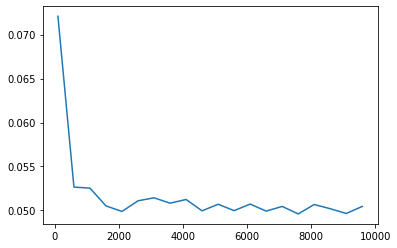

In [ ]:
ns = np.arange(100, 10000, step=500)
type_I_errors = np.zeros(len(ns))
for i, n in enumerate(ns):
  Sigma_hats = generate_subset_factor_sample_cov(n, C_chol, W, D, rho=None, B=100000, chi_sqrts=None, normals=None, S=None)
  type_I_errors[i] = np.mean(get_LRT_rejections(Sigma_hats, n, k, alpha=0.05, model='pcss'))
plt.plot(ns, type_I_errors)

Correlation in Errors

In [ ]:
ns = np.arange(100, 3000, step=500)
error_rhos = np.arange(0.0, 0.001, step=0.0001) 
type_I_errors = np.zeros((len(ns), len(error_rhos)))
for i, n in enumerate(ns):
  for j, error_rho in enumerate(error_rhos):
    Sigma_hats = generate_subset_factor_sample_cov(n, C_chol, W, D, rho=error_rho, B=10000, chi_sqrts=None, normals=None, S=None)
    type_I_errors[i, j] = np.mean(get_LRT_rejections(Sigma_hats, n, k, alpha=0.05, model='pcss'))

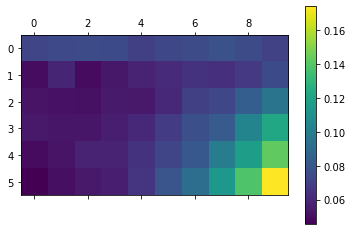

In [ ]:
 
figure = plt.figure()
axes = figure.add_subplot(111)
 
# using the matshow() function
caxes = axes.matshow(type_I_errors, interpolation ='nearest')
figure.colorbar(caxes)
 
plt.show()

t-distributed noise 

In [ ]:
ns = np.arange(100, 3000, step=500)
t_dfs = np.arange(10, 40, step=10) 
type_I_errors = np.zeros((len(ns), len(t_dfs)))
for i, n in enumerate(ns):
  for j, t_df in enumerate(t_dfs):
    print(n, t_df)
    X = generate_subset_factor_data(n, C_chol, W, D, rho=None, B=1000, S=None, mu=None, normals=None, noise='t', t_df=t_df)
    X_c = X - np.mean(X, axis=1)[:, np.newaxis, :]  
    Sigma_hats = 1/n * np.transpose(X_c, (0, 2, 1) ) @ X_c
    type_I_errors[i, j] = np.mean(get_LRT_rejections(Sigma_hats, n, k, alpha=0.05, model='pcss'))

100 10
100 20
100 30
600 10
600 20
600 30
1100 10
1100 20
1100 30
1600 10
1600 20
1600 30
2100 10
2100 20
2100 30
2600 10
2600 20
2600 30


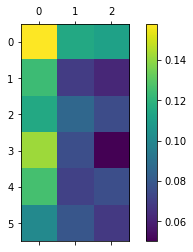

In [ ]:
figure = plt.figure()
axes = figure.add_subplot(111)
 
# using the matshow() function
caxes = axes.matshow(type_I_errors, interpolation ='nearest')
figure.colorbar(caxes)
 
plt.show()

Exponential Noise

In [ ]:
ns = np.arange(100, 3000, step=500)
type_I_errors = np.zeros(len(ns))
for i, n in enumerate(ns):
  print(n)
  X = generate_subset_factor_data(n, C_chol, W, D, rho=None, B=1000, S=None, mu=None, normals=None, noise='exponential')
  X_c = X - np.mean(X, axis=1)[:, np.newaxis, :]  
  Sigma_hats = 1/n * np.transpose(X_c, (0, 2, 1) ) @ X_c
  type_I_errors[i] = np.mean(get_LRT_rejections(Sigma_hats, n, k, alpha=0.05, model='pcss'))

100
600
1100
1600
2100
2600


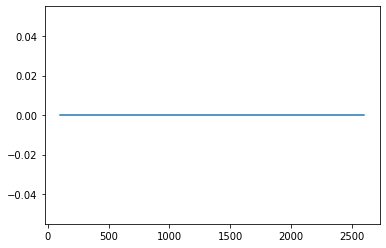

In [ ]:
plt.plot(ns, type_I_errors)

BREAK

In [ ]:
#@title
def cov_df(p):
  return int(p*(p+1)/2)

def MLCSS_df(p, k, model='sf'):
  if model == 'sf':
    return cov_df(k) + (p-k)*(k+ 1)
  if model == 'pcss':
    return cov_df(k) + (p-k)*k + 1 if k < p else cov_df(p)
  return 

def FA_df(p, k):
  return p*(k + 1) - int(k*(k-1)/2) if k < p else cov_df(p)

# Also returns fitted model if k < p 
def compute_likelihood(X_train, X_val, k, model_params, reduce_mean=True, check_errors=True):

  if check_errors:
    model_params = error_check_model_params(model_params)

  _, p = X_train.shape
  if k == p:
    mu_hat, Sigma_hat = get_moments(X_train)
    likelihood = stats.multivariate_normal(mean=mu_hat, cov=Sigma_hat).logpdf(X_val)
    if reduce_mean:
      likelihood = np.mean(likelihood)
    return likelihood, None

  num_tries = model_params['num_tries']

  if model_params['model'] == 'fa':
    FA = FactorAnalysis()
    if num_tries == 1:
      FA.compute_MLE_from_data(X_train, k, init=model_params['init'], max_iter=model_params['max_iter'])
      likelihood = FA.compute_log_likelihood(X_val)
    else:
      best_training_likelihood = -np.inf 
      W_init = None
      D_init = None 
      for _ in range(num_tries):
        FA.compute_MLE_from_data(X_train, k, init=model_params['init'], max_iter=model_params['max_iter'])
        training_likelihood  = FA.compute_log_likelihood(reduce_mean=True)
        if training_likelihood > best_training_likelihood:
          best_training_likelihood = training_likelihood 
          W_init = FA.W_init.copy()
          D_init - FA.D_init.copy()
      FA.compute_MLE_from_data(X_train, k, init=None, max_iter=model_params['max_iter'], W_init=W_init, D_init=D_init)
      likelihood = FA.compute_log_likelihood(X_val)
    model = FA 

  if model_params['model'] == 'mlcss':
    MLCSS = MLColumnSubsetSelection()
    if num_tries == 1:
      MLCSS.compute_MLE_from_data(X_train, k, model=model_params['sub_model'], method=model_params['method'], max_iter=model_params['max_iter'])
      likelihood = MLCSS.compute_log_likelihood(X_val)
    else:
      best_training_likelihood = -np.inf 
      S_init = None
      for _ in range(num_tries):
        MLCSS.compute_MLE_from_data(X_train, k, model=model_params['sub_model'], method=model_params['method'], max_iter=model_params['max_iter'])
        training_likelihood = MLCSS.compute_log_likelihood(reduce_mean=True)
        if training_likelihood > best_training_likelihood:
          best_training_likelihood = training_likelihood 
          S_init = MLCSS.S_init
      MLCSS.compute_MLE_from_data(X_train, k, model=model_params['sub_model'], method=model_params['method'], max_iter=model_params['max_iter'], S_init=S_init)
      likelihood = MLCSS.compute_log_likelihood(X_val)
    model=MLCSS
  
  if reduce_mean:
    likelihood = np.mean(likelihood)

  return likelihood, model 

def compute_lrt_statistic(X, k_null, k_alt, model_params, check_errors=True, alt_likelihood=None, bootstrap=False, B=0):
  
  if check_errors:
    model_params = error_check_model_params(model_params)

  bootstrap_dist = np.zeros(B)
  
  n, p = X.shape
  null_likelihood, null_model = compute_likelihood(X, X, k_null, model_params, reduce_mean=True, check_errors=False)
  if alt_likelihood is None:
    alt_likelihood, _ = compute_likelihood(X, X, k_alt, model_params, reduce_mean=True, check_errors=False)

  if bootstrap:
    for i in range(B):
      X_B = generate_data(n, null_model.MLE , model_params, check_errors=False)
      stat_B, _ = compute_lrt_statistic(X_B, k_null, k_alt, model_params, check_errors=False)
      bootstrap_dist[i] = stat_B

  return 2*n*(alt_likelihood - null_likelihood), bootstrap_dist

def compute_split_lrt_statistic(X, k_null, k_alt, model_params, check_errors=True, alt_likelihood=None, bootstrap=False, B=None):
  
  if check_errors:
    model_params = error_check_model_params(model_params)

  n, p = X.shape
  n_half = int(n/2)
  X0 = X[:n_half, :]
  X1 = X[n_half:, :] 


  null_likelihood, null_model = compute_likelihood(X0, X0, k_null, model_params, reduce_mean=True, check_errors=False)
  if alt_likelihood is None:
    alt_likelihood = compute_likelihood(X1, X0, k_alt, model_params, reduce_mean=True, check_errors=False)
  
  return n_half*(alt_likelihood - null_likelihood)

def compute_crossfit_lrt_statistic(X, k_null, k_alt, model_params, check_errors=True, alt_likelihood=[None, None], bootstrap=False, B=None):
  
  if check_errors:
    model_params = error_check_model_params(model_params)

  n, p = X.shape
  n_half = int(n/2)
  X0 = X[:n_half, :]
  X1 = X[n_half:, :]

  null_likelihood = compute_likelihood(X0, X0, k_null, model_params, reduce_mean=True, check_errors=False)
  if alt_likelihood[0] is None:
    alt_likelihood[0] = compute_likelihood(X1, X0, k_alt, model_params, reduce_mean=True, check_errors=False)
  stat1 = n_half * (alt_likelihood[0] - null_likelihood)
  
  null_likelihood = compute_likelihood(X1, X1, k_null, model_params, reduce_mean=True, check_errors=False)
  if alt_likelihood[1] is None:
    alt_likelihood[1] = compute_likelihood(X0, X1, k_alt, model_params, reduce_mean=True, check_errors=False)
  stat2 = (n - n_half) * (alt_likelihood[1] - null_likelihood)

  return stat1 + np.log(1 +  np.exp(stat2 - stat1)) - np.log(2)

def select_number_of_factors(X, 
                             alpha, 
                             model_params, 
                             sequential=True, 
                             test='lrt', 
                             bootstrap=False, 
                             B=0,
                             bartlett=False):
  n, p = X.shape
 
  # set-up 
  test = test.lower()
  if test not in {'lrt', 'split_lrt', 'crossfit_lrt'}:
    raise ValueError("test is not supported.")
  if p == 1:
    return n
  model_params = error_check_model_params(model_params)
  if p == 1:
    raise ValueError("model selection requires p > 1")
  if model_params['model'] == 'fa' and p <= 3:
    raise ValueError("LRT with Factor Analysis requires p > 3")
  k_null = 1 
  if sequential:
    k_alt = 2
  else:
    k_alt = p 
  limit = p
  if model_params['model'] == 'fa':
    limit = np.floor((p-1)/2)
  alt_likelihood = None if test != 'crossfit_lrt' else [None, None]
  
  # if testing against full model, compute and store alternative likelihood
  if not sequential:
    if test == 'lrt':
      alt_likelihood, _ = compute_likelihood(X, X, p, model_params, reduce_mean=True, check_errors=False)
    n_half = int(n/2)
    X0 = X[:n_half, :]
    X1 = X[n_half:, :]
    if test == 'split_lrt':
      alt_likelihood, _ = compute_likelihood(X1, X0, p, model_params, reduce_mean=True, check_errors=False)
    if test == 'crossfit_lrt':
      alt_likelihood, _ = [compute_likelihood(X1, X0, p, model_params, reduce_mean=True, check_errors=False),
                        compute_likelihood(X0, X1, p, model_params, reduce_mean=True, check_errors=False)]
  
  # sequential testing 
  while k_null <= limit:
    if k_null == limit and sequential:
      k_alt = p

    if test == 'lrt':
      stat, bootstrap_dist = compute_lrt_statistic(X, 
                                                   k_null, 
                                                   k_alt, 
                                                   model_params, 
                                                   check_errors=False, 
                                                   alt_likelihood=alt_likelihood, 
                                                   bootstrap=bootstrap, 
                                                   B=B)
      if bootstrap:
        thresh = np.quantile(bootstrap_dist, 1-alpha)
      else:
        if model_params['model'] == 'fa':
          df = FA_df(p, k_alt) - FA_df(p, k_null)
        if model_params['model'] == 'mlcss':
          df = MLCSS_df(p, k_alt, model=model_params['sub_model']) - MLCSS_df(p, k_null, model=model_params['sub_model'])
        thresh = chi2.ppf(1-alpha, df)
    
    if test == 'split_lrt':
      stat = compute_split_lrt_statistic(X, 
                                         k_null, 
                                         k_alt, 
                                         model_params, 
                                         check_errors=False, 
                                         alt_likelihood=alt_likelihood,
                                         bootstrap=bootstrap, 
                                         B=B)
      if bootstrap:
        thresh = np.quantile(bootstrap_dist, 1-alpha)
      else:
        thresh = np.log(1/alpha)
    
    if test == 'crossfit_lrt':
      stat = compute_crossfit_lrt_statistic(X, 
                                            k_null, 
                                            k_alt, 
                                            model_params, 
                                            check_errors=False, 
                                            alt_likelihood=alt_likelihood,
                                            bootstrap=bootstrap, 
                                            B=B)
      
      if bootstrap:
        thresh = np.quantile(bootstrap_dist, 1-alpha)
      else:
        thresh = np.log(1/alpha)

    
    if stat <= thresh:
      return k_null 
    else:
      k_null += 1
      if sequential:
        k_alt += 1

  return k_alt


In [ ]:
r = 8
p=50
k=10
n=int(p*k*r)
N=100
alpha=0.05
SNR=9
num_tries=10
model='pcss'
method='swap'
max_iter = 100

p_to_block_structure = {10 : {'num_blocks' : 2 ,  'block_size': 1, 'overlap': 0},
                        20 : {'num_blocks' : 3 ,  'block_size': 2, 'overlap': 1},
                        50 : {'num_blocks' : 4 ,  'block_size': 4, 'overlap': 2}}

In [ ]:
def cov_df(p):
  return int(p*(p+1)/2)

def get_df(p, k, model):
  if model == 'sf':
    return cov_df(k) + (p-k)*(k+ 1)
  if model == 'pcss':
    return cov_df(k) + (p-k)*k + 1 if k < p else cov_df(p)

#def mp_MLCSS_likelihood_from_cov(Sigma):
#  MLCSS = MLColumnSubsetSelection()
#  MLCSS.compute_MLE_from_cov(Sigma, k_null, model=model, method=method, max_iter=max_iter)
#  return MLCSS.compute_log_likelihood(reduce_mean=True)

def mean_gaussian_log_likelihood_from_log_det(p, log_det):
  return -1/2*(p * np.log(2 * np.pi) + p + log_det)

def MLCSS_model_selection_with_LRT(Sigma_hat,
                                   n, 
                                   alpha, 
                                   model='pcss',
                                   method='swap',
                                   B=0,
                                   bartlett=False,
                                   num_tries=1,
                                   max_iter=100):

  p = Sigma_hat.shape[0]
  if B > 0:
    chis = np.random.chisquare(df=np.arange(n - 1, n - p - 1 , -1), size=(B,p))
    chi_sqrts = np.sqrt(chis)
    normals = np.random.normal(0, 1, (B, int(p*(p-1)/2)) )
  
  k_null = 1
  alt_log_likelihood = -1/2*(p * np.log(2 * np.pi) + p + np.log(np.linalg.det(Sigma_hat)))
  alt_df = cov_df(p)
  
  MLCSS = MLColumnSubsetSelection()
  while k_null < p:
    
    null_log_likelihood = -np.inf 
    C_chol_null = None
    W_null = None
    D_null = None

    for _ in range(num_tries):
      MLCSS.compute_MLE_from_cov(Sigma_hat, k_null, model=model, method=method) #Change this
      potential_null_log_likelihood = MLCSS.compute_log_likelihood(reduce_mean=True)
      if potential_null_log_likelihood > null_log_likelihood:
        null_log_likelihood = potential_null_log_likelihood 
        if B > 0:
          C_chol_null = MLCSS._Sigma_S_L
          W_null = MLCSS.MLE["W_MLE"]
          if model == 'sf':
            D_null = MLCSS.MLE["D_MLE"]
          if model == 'pcss':
            D_null = MLCSS.MLE["sigma_sq_MLE"]

    if B == 0:
      stat = 2 * n * (alt_log_likelihood - null_log_likelihood)
      df = alt_df - MLCSS_df(p, k_null, model)
      thresh = chi2.ppf(1-alpha, df)
    else:
      stats_B = np.zeros(B)
      Sigma_hat_B = generate_MLCSS_Sigma_hat(n, C_chol_null, W_null, D_null, B=B, chi_sqrts=chi_sqrts, normals=normals)
      for i in range(B):
        alt_log_likelihood_B = -1/2*(p * np.log(2 * np.pi) + p + np.log(np.linalg.det(Sigma_hat_B[i, :, :])))
        null_log_likelihood_B = -np.inf 
        for _ in range(num_tries):
          MLCSS.compute_MLE_from_cov(Sigma_hat_B[i, :, :], k_null, model=model, method=method, max_iter=0, S_init=np.arange(k_null)) #CHANGE
          null_log_likelihood_B = max(null_log_likelihood_B, MLCSS.compute_log_likelihood(reduce_mean=True))
        stats_B[i] = alt_log_likelihood_B - null_log_likelihood_B
      stats_B *= 2*n

      if bartlett:
        stat = 2 * n * (alt_log_likelihood - null_log_likelihood)
        df = alt_df - MLCSS_df(p, k_null, model)
        stat *= df/np.mean(stats_B)
        thresh = chi2.ppf(1-alpha, df)
      else:
        stat = 2 * n * (alt_log_likelihood - null_log_likelihood)
        thresh = np.quantile(stats_B, 1 - alpha)

    if stat < thresh:
      return k_null

    k_null += 1
  
  return k_null 


def run_model_selection_tests(setting):
  C_chol = get_equicorrelated_C_chol(setting["k"], setting["rho"])
  W = get_block_W(setting["p"], setting["k"] , setting["num_blocks"], setting["block_size"], setting["overlap"], setting["SNR"])
  D = 1/(1 + setting["SNR"])
  Sigma_hats = generate_MLCSS_Sigma_hat(setting["n"], C_chol, W, D, B=setting["N"])
  Sigma_hats = list(Sigma_hats)

  func = partial(MLCSS_model_selection_with_LRT, 
                 n=setting["n"], 
                 alpha=setting["alpha"], 
                 model=setting["model"],
                 method=setting["method"],
                 B=setting["B"],
                 bartlett=setting["bartlett"],
                 num_tries=setting["num_tries"],
                 max_iter=setting["max_iter"])
  
  results = []
  with Pool() as pool:
    for result in tqdm(pool.imap(func, Sigma_hats)):
      results.append(result)
  results = np.array(results)

  power = np.mean(results == setting["k"])
  type_I_error = np.mean(results > setting["k"])
  row = setting.copy()
  row['power'] = power
  row['type_I_error'] = type_I_error
  return row


In [ ]:
X = generate_MLCSS_X(1000, C_chol, W, D)
mu_hat, Sigma_hat = get_moments(X)
print(mean_gaussian_log_likelihood_from_log_det(p, np.log(np.linalg.det(Sigma_hat))))
print(np.mean(stats.multivariate_normal(mean=mu_hat, cov=Sigma_hat).logpdf(X)))

-23.302119099691794
-23.30211909969185


In [ ]:
full_flag = True

B = 1000
violation = 0 
for i in tqdm(range(B)):
  Sigma_hat = generate_MLCSS_Sigma_hat(n, C_chol, W, D)
  MLCSS = MLColumnSubsetSelection()
  #MLCSS.compute_MLE_from_cov(Sigma_hat, k, method='swap', model='pcss', max_iter=0, S_init=np.arange(k) )
  MLCSS.compute_MLE_from_cov(Sigma_hat, k, method='swap', model='pcss', max_iter=0, S_init=np.arange(k) )
  null_likelihood = MLCSS.compute_log_likelihood(reduce_mean=True)
  if full_flag:
    alt_likelihood = mean_gaussian_log_likelihood_from_log_det(p, np.log(np.linalg.det(Sigma_hat)))
    df = cov_df(p) - MLCSS_df(p, k, model)
  else:
    MLCSS = MLColumnSubsetSelection()
    MLCSS.compute_MLE_from_cov(Sigma_hat, k+1, method='swap', model='pcss', S_init=np.arange(k+1), max_iter=0)
    #print(MLCSS.S)
    alt_likelihood = MLCSS.compute_log_likelihood(reduce_mean=True)
    df = MLCSS_df(p, k+1, model) - MLCSS_df(p, k, model)
  stat = 2*n*(alt_likelihood - null_likelihood)
  if stat > chi2.ppf(1-alpha, df):
    violation += 1

print(violation/B)


  0%|          | 0/1000 [00:00<?, ?it/s]

0.065


Check if correct subset is found

In [ ]:
MLCSS = MLColumnSubsetSelection()
missed = 0
for i in tqdm(range(N)):
  X = Sigma_hat = generate_MLCSS_Sigma_hat(n, C_chol, W, D)
  correct = 0
  for j in range(num_tries):
    MLCSS = MLColumnSubsetSelection()
    MLCSS.compute_MLE_from_cov(Sigma_hat, k, method='swap', model='pcss')
    if MLCSS.S == set(list(range(k))):
      correct = 1
      break
  missed += 1 - correct

print(missed/N)

  0%|          | 0/100 [00:00<?, ?it/s]

0.0


In [ ]:
run_model_selection_tests(settings[-1])


0it [00:00, ?it/s]

{'num_tries': 10,
 'N': 1000,
 'model': 'pcss',
 'method': 'swap',
 'max_iter': 100,
 'B': 0,
 'bartlett': False,
 'p': 50,
 'k': 10,
 'n': 4000,
 'alpha': 0.05,
 'SNR': 9,
 'rho': 0.25,
 'num_blocks': 4,
 'block_size': 4,
 'overlap': 2,
 'power': 0.925,
 'type_I_error': 0.075}

In [ ]:

ps=np.array([20, 50])
k_over_ps=np.array([0.2])
n_over_num_pks =np.array([4, 8])

alphas=np.array([0.05])
SNRs=np.array([3, 9])
rhos = np.array([0.25])
num_tries=10
N = 1000
model='pcss'
method='swap'
max_iter = 100
B = 0
bartlett=False


p_to_block_structure = {10 : {'num_blocks' : 2 ,  'block_size': 1, 'overlap': 0},
                        20 : {'num_blocks' : 3 ,  'block_size': 2, 'overlap': 1},
                        50 : {'num_blocks' : 4 ,  'block_size': 4, 'overlap': 2}}

settings = []
for t in tqdm(list(itertools.product(*[ps, k_over_ps, n_over_num_pks, alphas, SNRs, rhos]))):
  p = t[0]
  k = int(p * t[1])
  n = int(p * k * t[2])
  alpha = t[3]
  SNR = t[4]
  rho = t[5]
  setting = {'num_tries': num_tries,
             'N': N,
             'model': 'pcss',
             'method': 'swap',
             'max_iter': max_iter,
             'B': B,
             'bartlett': bartlett,
             'p': p,
             'k': k,
             'n': n,
             'alpha': alpha,
             'SNR': SNR,
             'rho': rho,
             'num_blocks': p_to_block_structure[p]['num_blocks'],
             'block_size': p_to_block_structure[p]['block_size'],
             'overlap':  p_to_block_structure[p]['overlap']
             }


  settings.append(setting)

  0%|          | 0/8 [00:00<?, ?it/s]

Selection on real data

In [ ]:
stocks_df = pd.read_csv('stocks_normalized.csv')
stocks = list(stocks_df.columns)[1:]
X = stocks_df.to_numpy()[:, 1:].astype(float)
mu_hat, Sigma_hat = get_moments(X)
n, p = X.shape
X_standardized = diagonal_right_multiply(X - mu_hat, 1/np.sqrt(np.diag(Sigma_hat))) + mu_hat
mu_hat, Sigma_hat = get_moments(X_standardized)

In [ ]:
df = pd.read_csv('BFI228.csv')
X = df.to_numpy()[:, 1:].astype(float)
mu_hat, Sigma_hat = get_moments(X)
n, p = X.shape

In [ ]:
(n, p)

(228, 44)

In [ ]:
df = pd.read_csv('survey.csv')
X = df.to_numpy()[:, 1:].astype(float)
mu_hat, Sigma_hat = get_moments(X)
n, p = X.shape

In [ ]:
alpha=0.05
model='sf'
MLCSS = MLColumnSubsetSelection()
full_likelihood = compute_full_gaussian_likelihood(Sigma_hat)
k = 1
while True:
  print(k)
  null_likelihood = -np.inf
  for j in range(100):
    MLCSS.compute_MLE_from_cov(Sigma_hat, k, model=model, method='swap')
    possible_null_likelihood = MLCSS.compute_log_likelihood(reduce_mean=True)
    if possible_null_likelihood > null_likelihood:
      null_likelihood = possible_null_likelihood
  df = cov_df(p) - model_df(p, k, model=model)
  stat = 2*n*(full_likelihood - null_likelihood)
  if stat > chi2.ppf(1-alpha, df):
    k = k + 1
    continue
  else:
    break
print(k)


1
2
3
4
5
6
7
8
9
10
11
11


In [ ]:
np.array(stocks)[np.array(list(MLCSS.S))]

array(['MSFT', 'META', 'BAC', 'JPM', 'C', 'GSK', 'NVS', 'BMY', 'LMT',
       'NOC', 'RTX', 'TXT'], dtype='<U4')

In [ ]:
stocks[np.array(MLCSS.S)]

TypeError: ignored

In [ ]:
MLCSS.compute_MLE_from_cov(Sigma_hat_standardized, 1, model='pcss', method='swap')

In [ ]:
Sigma_MLE = compute_Sigma_MLE(Sigma_hat_standardized, np.array([6]))
Sigma_MLE = perm(Sigma_MLE, np.array([0, 6]), np.array([6, 0]))
compute_model_gaussian_likelihood( Sigma_MLE, k=1, model='pcss')

array(-25.68038997)

In [ ]:
MLCSS.compute_log_likelihood(reduce_mean=True)

-25.68038997160454

In [ ]:
(MLCSS.compute_log_likelihood(reduce_mean=True))

{'mu_MLE': None,
 'S_MLE': {6},
 'C_MLE': array([[1.]]),
 'W_MLE': array([[0.28620121],
        [0.29325858],
        [0.36113827],
        [0.16175249],
        [0.24498149],
        [0.91455684],
        [0.81808313],
        [0.71536988],
        [0.82468404],
        [0.25225098],
        [0.23236375],
        [0.26925142],
        [0.27994059],
        [0.25793973],
        [0.26600141],
        [0.23584004],
        [0.61895537],
        [0.68211623],
        [0.55333303]]),
 'sigma_sq_MLE': 0.7527364797729622}

# Regularized CSS

In [ ]:
p = 40
k = 5

A = np.random.normal(0, 2.5, size=(p, k))
D = np.square(np.random.normal(0, 3, size=p))
Sigma = A @ A.T + np.diag(D)
Sigma = standardize_cov(Sigma)



In [ ]:
np.round(D/(np.sum(np.square(A), axis=1) + D), 3)

array([0.497, 0.077, 0.64 , 0.159, 0.162, 0.083, 0.342, 0.116, 0.002,
       0.036, 0.9  , 0.031, 0.003, 0.019, 0.27 , 0.114, 0.324, 0.364,
       0.533, 0.724, 0.324, 0.616, 0.861, 0.179, 0.001, 0.602, 0.006,
       0.012, 0.001, 0.048, 0.158, 0.013, 0.043, 0.524, 0.192, 0.388,
       0.183, 0.084, 0.   , 0.612])

In [ ]:
idxs_list = [np.array(idxs) for idxs in list(itertools.combinations(range(p), k))]
lowest = np.inf
S_best = np.nan
for idxs in tqdm(idxs_list):
  resid = regress_off(Sigma, idxs)
  avg_resid = np.trace(resid)/(p-k)
  if avg_resid < lowest:
    S_best = idxs
    lowest = avg_resid
print(S_best)

  0%|          | 0/658008 [00:00<?, ?it/s]

[ 8 12 24 28 38]


In [ ]:
X_train = np.random.multivariate_normal(np.zeros(p), Sigma, size=100)
mu_train, Sigma_train = get_moments(X_train)
CSS = ColumnSubsetSelection()
CSS.select_subset_from_cov(Sigma_train, k, method='swap')
CSS.S

{8, 12, 24, 28, 38}

In [ ]:
def get_generalization_errors(Sigma, k, ns, lambs=[0], B=100, n_test=10000):
  results = np.zeros((len(ns), len(lambs)))
  
  for i in range(B):
    X_train = np.random.multivariate_normal(np.zeros(p), Sigma, size=np.max(ns))
    X_test = np.random.multivariate_normal(np.zeros(p), Sigma, size=n_test)
    _, Sigma_test = get_moments(X_test)  
  
    for j1, lamb in enumerate(lambs):
      for j2, n in enumerate(ns):
        _, Sigma_train = get_moments(X_train[:n, :])
        Sigma_train = Sigma_train + lamb * np.eye(p)
        CSS = ColumnSubsetSelection()
        CSS.select_subset_from_cov(Sigma_train, k, method='swap')
        CSS.select_subset_from_cov(Sigma_test, k=k, method='swap', S_init=CSS.S, max_iter=0)
        results[j2, j1] += np.trace(CSS.Sigma_R)/(p-k)
  return results/B

In [ ]:
lambs = np.concatenate([[0], np.logspace(-5, 0, 5)])
ns = np.array([50, 100, 150, 200, 250])
results = get_generalization_errors(Sigma, 5, ns, lambs=lambs)

In [ ]:
results

array([[0.21222106, 0.21236923, 0.21243943, 0.21287282, 0.22585996,
        0.28010585],
       [0.21199557, 0.21201284, 0.21204782, 0.21257108, 0.22369877,
        0.24869086],
       [0.21181873, 0.21190115, 0.21191983, 0.21225341, 0.22230616,
        0.24471982],
       [0.21177786, 0.21177786, 0.21178678, 0.21211385, 0.2230416 ,
        0.24372491],
       [0.2117602 , 0.2117602 , 0.2117602 , 0.21214439, 0.22350538,
        0.23893147]])

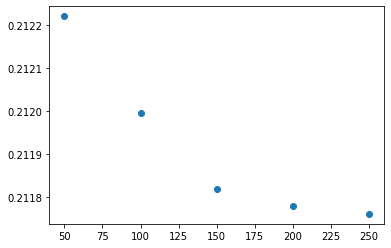

In [ ]:
plt.scatter(ns, results[:, 0])

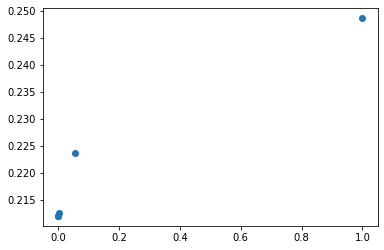

In [ ]:
plt.scatter(lambs, results[1, :])

In [ ]:
def get_generalization_error(X_train, X_test, k, method='greedy', lamb=1, num_init=1):
  
  mu_train, Sigma_train = get_moments(X_train)
  np.fill_diag(Sigma_train, np.diag(Sigma_train) + lamb)
  CSS = ColumnSubsetSelection() 

  if num_init == 1:
    CSS.select_subset_from_cov(Sigma_train, k, method=method)
  else:
    training_error = np.inf
    S_init = np.nan
    for i in range(num_init):
      CSS.select_subset_from_cov(Sigma_train, k, method=method)
      curr_training_error = np.mean(np.diag(CSS.Sigma_R))




#Fitting Mixture Models


Synthetic data

In [ ]:
p=10
k=3
SNR=10
n=1000
pi = np.array([0.7, 0.3])
params = {}
for i in range(2):
  t = randomly_generate_MLCSS_params(p, k, model='sf', SNR=SNR, standardize=True)
  params[i] = {'C_sqrt': t[0], 'W': t[1], 'D': t[2]}
params[1]['S'] = np.arange(p-k, p)
X = generate_MLCSS_mixture_data(n, pi, params)

In [ ]:
MMLCSS = MMLColumnSubsetSelection()
MMLCSS.compute_mixture_MLE_from_data(X, 2, np.array([3, 3]), model='sf', check_every=1, max_iter=1000)


In [ ]:
w = len(MMLCSS.log_likelihood_history)
plt.plot([MMLCSS.log_likelihood_history[i][0] for i in range(w)], [MMLCSS.log_likelihood_history[i][1] for i in range(w)])

In [ ]:
MMLCSS.pi_MLE

In [ ]:
plt.scatter(range(len(MMLCSS.compute_posterior_class_probs()[:, 0])), MMLCSS.compute_posterior_class_probs()[:, 0] )

Data from: https://archive.ics.uci.edu/ml/datasets/spambase

In [ ]:
spam_cols = ['word_freq_make',
'word_freq_all',          
'word_freq_address',      
'word_freq_3d',           
'word_freq_our',          
'word_freq_over',         
'word_freq_remove',       
'word_freq_internet',     
'word_freq_order',        
'word_freq_mail',         
'word_freq_receive',      
'word_freq_will',         
'word_freq_people',       
'word_freq_report',       
'word_freq_addresses',    
'word_freq_free',         
'word_freq_business',     
'word_freq_email',        
'word_freq_you',          
'word_freq_credit',       
'word_freq_your',         
'word_freq_font',         
'word_freq_000',          
'word_freq_money',        
'word_freq_hp',           
'word_freq_hpl',          
'word_freq_george',       
'word_freq_650',          
'word_freq_lab',          
'word_freq_labs',         
'word_freq_telnet',       
'word_freq_857',          
'word_freq_data',         
'word_freq_415',          
'word_freq_85',           
'word_freq_technology',   
'word_freq_1999',         
'word_freq_parts',       
'word_freq_pm',      
'word_freq_direct',       
'word_freq_cs',     
'word_freq_meeting',    
'word_freq_original',     
'word_freq_project',      
'word_freq_re',         
'word_freq_edu',       
'word_freq_table',  
'word_freq_conference',   
'char_freq_;',           
'char_freq_(',           
'char_freq_[',           
'char_freq_!',           
'char_freq_$',           
'char_freq_#',            
'capital_run_length_average',
'capital_run_length_longest',
'capital_run_length_total',
'spam_label']

spam_df =  pd.read_csv('spambase.csv', sep=",", header=None)
old_cols = spam_df.columns
rename_cols = {old_cols[i]: spam_cols[i] for i in range(len(old_cols))}
spam_df = spam_df.rename(columns=rename_cols)

remove_cols = [           
'capital_run_length_average',
'capital_run_length_longest',
'capital_run_length_total',
'word_freq_table',                
'word_freq_parts',  
'char_freq_[',         
'word_freq_conference',
'char_freq_;',        
'word_freq_cs',        
'char_freq_#',         
'word_freq_original', 
'word_freq_857',       
'word_freq_415',       
'word_freq_addresses', 
'word_freq_report',    
'word_freq_receive',   
'word_freq_telnet',    
'word_freq_direct',    
'word_freq_3d',       
'char_freq_$',         
'word_freq_pm']
#spam_df = spam_df.drop(remove_cols, axis=1)

data = spam_df.to_numpy()
y = data[:, -1]
X = data[:, :data.shape[1] - 1]
#X = box_cox(X, 0.01)
X = standardize_data(X)
#X -= 

In [ ]:
spam_df.sum().sort_values()

Data from: https://archive.ics.uci.edu/ml/datasets/cloud

In [ ]:
cloud_df = pd.read_csv('cloud.data')

Data from: https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)

In [ ]:
breast_df = pd.read_csv('breast-cancer-wisconsin.data')

#breast_df.columns = ['Id', 'Clump_thickness', 'Uniformity_cell_size', 'Uniformity_cell_shape', 'Marginal_adhesion', 'Single_e_cell_size', 'Bare_nuclei', 'Bland_chromatin', 'Normal_nucleoli', 'Mitoses', 'Class']
#breast_df.loc[breast_df["Class"] == 2, "Class"] = 0
#breast_df.loc[breast_df["Class"] == 4, "Class"] = 1
breast_df = breast_df.drop(np.where(np.sum(breast_df == '?', axis=1))[0], axis=0)
#breast_df = breast_df.drop("Bare_nuclei", axis=1)

data = breast_df.to_numpy().astype(float)
y = data[:, -1]
X = data[:, 1:data.shape[1] - 1]
#X = box_cox(X, 0.01)
X = standardize_data(X)

In [ ]:
#@title
breast_df = pd.read_csv('wdbc.data', header=None)
breast_df.columns = np.arange(len(breast_df.columns)).astype(str)
breast_df.loc[breast_df["1"] == 'M', breast_df["1"]] = 1
print(breast_df.columns)

#breast_df.columns = ['Id', 'Clump_thickness', 'Uniformity_cell_size', 'Uniformity_cell_shape', 'Marginal_adhesion', 'Single_e_cell_size', 'Bare_nuclei', 'Bland_chromatin', 'Normal_nucleoli', 'Mitoses', 'Class']
#breast_df.loc[breast_df["Class"] == 2, "Class"] = 0
#breast_df.loc[breast_df["Class"] == 4, "Class"] = 1
breast_df = breast_df.drop(np.where(np.sum(breast_df == '?', axis=1))[0], axis=0)
breat_df 
breast_df = breast_df.drop([0, 1], axis=1)
print(breast_df.head())
break

data = breast_df.to_numpy().astype(float)
y = data[:, 1]
X = data[:, 1:data.shape[1] - 1]
#X = box_cox(X, 0.01)
X = standardize_data(X)

In [ ]:
for i, col in enumerate(breast_df.columns):
  print(col)
  plt.hist(X[:, i])
  plt.show()

In [ ]:
MMLCSS = MMLColumnSubsetSelection()
likelihoods = []
k_max = 9
for i in range(1, k_max+1):
  MMLCSS.compute_mixture_MLE_from_data(X, 2, np.array([i, i]), model='pcss', check_every=1, max_iter=1000, tol=0)
  likelihoods.append(MMLCSS.compute_log_likelihood(reduce_mean=True))
plt.plot(range(1, k_max+1), likelihoods)



In [ ]:
MMLCSS = MMLColumnSubsetSelection()
MMLCSS.compute_mixture_MLE_from_data(X, 2, np.array([36, 36]), model='sf', check_every=1, max_iter=1000, tol=0)

In [ ]:
plt.plot(*zip(*MMLCSS.log_likelihood_history))
print(MMLCSS.converged)

In [ ]:
print(np.mean((MMLCSS.compute_posterior_class_probs()[:, 1] > 0.5) == y))
print(np.mean((MMLCSS.compute_posterior_class_probs()[:, 0] > 0.5) == y))

In [ ]:
display_MLCSS_results(MMLCSS.models[0].MLE, breast_df.columns[1:len(breast_df.columns) -1])

In [ ]:
display_MLCSS_results(MMLCSS.models[1].MLE, breast_df.columns[1:len(breast_df.columns) -1])

# Alternative to Factor Analysis

In [ ]:
def display_MLCSS_results(MLE, column_names=None, round=2):
  k = MLE["C_MLE"].shape[0]
  p = k + MLE["D_MLE"].shape[0]
  if column_names is None:
    column_names = np.arange(p)
  S = np.sort(list(MLE["S_MLE"]))
  S_comp = complement(p, S)
  columns = np.concatenate([column_names[S], ['Communality', 'Uniqueness', 'Total Var', 'Mean']])
  index = column_names.copy()
  values = np.zeros((p, k + 4))
  values[S, :k] = np.eye(k)
  values[S, k] = np.diag(MLE["C_MLE"])
  values[S, k+1] = 0
  values[S, k+2] = values[S, k]
  values[S_comp, :k] = MLE["W_MLE"]
  values[S_comp, k] = np.diag(MLE["W_MLE"] @ MLE["C_MLE"] @ MLE["W_MLE"].T)
  values[S_comp, k+1] = MLE["D_MLE"]
  values[S_comp, k+2] = values[S_comp, k] + values[S_comp, k+1]
  values[:, k+3] = MLE["mu_MLE"]
  if round is not None:
    values = np.round(values, 3)
  results_df = pd.DataFrame(data=values,
                            index=index,
                            columns=columns) 
  return results_df

def display_FA_results(MLE, column_names=None, round=2):
  p = MLE["D_MLE"].shape[0]
  k = MLE["W_MLE"].shape[1]
  if column_names is None:
    column_names = np.arange(p)
  columns = np.concatenate([["Factor " + str(i) for i in range(k)], ['Communality', 'Uniqueness', 'Total Var', 'Mean']])
  index = column_names.copy()
  values = np.zeros((p, k + 4))
  values[:, :k] = MLE["W_MLE"]
  values[:, k] = np.sum(np.square(MLE["W_MLE"]), axis=1)
  values[:, k+1] = MLE["D_MLE"]
  values[:, k+2] = values[:, k+1] + values[:, k+2]
  values[:, k+3] = MLE["mu_MLE"]
  if round is not None:
    values = np.round(values, 3)
  results_df = pd.DataFrame(data=values,
                            index=index,
                            columns=columns) 
  return results_df


In [ ]:
def CSS_scree_plot_from_data(X_train, k_max, X_val=None, method='greedy', max_iter=100, num_tries=1, show_zero=False, plot=False):
  _, Sigma_hat_train = get_moments(X_train)
  if X_val is None:
    Sigma_hat_val = None
  else:
    _, Sigma_hat_val = get_moments(X_val) 
  return CSS_scree_plot_from_cov(Sigma_hat_train,
                                 k_max, 
                                 Sigma_val=Sigma_hat_val, 
                                 method=method,
                                 max_iter=max_iter, 
                                 num_tries=num_tries,
                                 show_zero=show_zero,
                                 plot=plot)

# fix this 
def CSS_scree_plot_from_cov(Sigma_train, k_max, Sigma_val=None, method='greedy', max_iter=100, num_tries=1, show_zero=False, plot=False):
  p = Sigma_train.shape[0]
  CSS = ColumnSubsetSelection()
  RMSE = np.zeros(k_max)
  subset_sizes = np.arange(1, k_max + 1)
  if method == 'greedy':
    CSS.select_subset_from_cov(Sigma_train, k=k_max, method='greedy')
    if Sigma_val is None:
      Sigma_R = Sigma_train.copy()
    else:
      Sigma_R = Sigma_val.copy()
    for i, s in enumerate(CSS.S_ordered):
      regress_one_off_in_place(Sigma_R, s)
      RMSE[i] = np.sqrt(np.trace(Sigma_R))
  if method == 'swap':
    for i in subset_sizes:
      RMSEs = np.zeros(num_tries)
      for j in range(num_tries):
        CSS.select_subset_from_cov(Sigma_train, k=i, method='swap', max_iter=max_iter)
        if Sigma_val is None:
          RMSEs[j] =  np.sqrt(np.trace(CSS.Sigma_R))
        else:
          RMSEs[j] = np.sqrt(np.trace(regress_off(Sigma_val, CSS.S)))
      RMSE[i - 1] = np.min(RMSEs)
  if plot:
    if show_zero:
      plt.plot(np.concatenate([[0], subset_sizes]), np.concatenate([[np.sqrt(np.trace(Sigma_train))], RMSE]))
    else:
      plt.plot(subset_sizes, RMSE)
    plt.title("RSME vs. Increasing Subset Sizes")
    plt.xlabel("Subset Size")
    plt.ylabel("RMSE")
  return RMSE

In [ ]:
def likelihood_plot_from_data(X_train, k_max, model_params, X_val=None, check_errors=True, plot=False):
  
  if check_errors:
    model_params = error_check_model_params(model_params)
  
  if X_val is None:
    X_val = X_train.copy()

  likelihoods = np.zeros(k_max)
  for k in range(1, k_max + 1):
    likelihood, _ = compute_likelihood(X_train, X_val, k, model_params, reduce_mean=True, check_errors=False)
    likelihoods[k-1] = likelihood
  
  if plot:
    plt.plot(range(1, len(likelihoods) + 1), likelihoods)
    plt.title("Average Log Likelihood vs. Increasing Num Factors")
    plt.xlabel("Num Factors")
    plt.ylabel("Average Log Likelihood")
    plt.show()

  return likelihoods 


In [ ]:
class FactorAnalysis:
  def __init__(self):
    pass

  def _compute_Sigma_MLE_inv(self):
    temp = np.eye(self.k) + diagonal_right_multiply(self.W.T, self._D_inv) @ self.W

    self._Sigma_MLE_inv = np.diag(self._D_inv) - diagonal_left_multiply(self._D_inv, diagonal_right_multiply(self.W @ np.linalg.solve(temp, self.W.T), self._D_inv))

  def _compute_Sigma_MLE_log_det(self):
    self._log_det_Sigma_MLE = np.sum(np.log(self.D)) + np.log(np.linalg.det(np.eye(self.k) + self.W.T @ diagonal_left_multiply(self._D_inv, self.W)))

  def compute_log_likelihood(self, X=None, reduce_mean=False):
    if X is None:
      try:
       X = self.X
      except:
        raise ValueError("X not provided and no default value available")

    X_centered = X - np.mean(X, axis=0)

    log_likelihoods = -1/2*(self.p * np.log(2 * np.pi) +  
                            self._log_det_Sigma_MLE + 
                            quadratic_form(X_centered, self._Sigma_MLE_inv , X_centered))
    if reduce_mean:
      return np.mean(log_likelihoods)
    else:
      return log_likelihoods 
  
  def compute_likelihood(self, X=None, reduce_geometric_mean=False):
    if X is None:
      try:
       X = self.X
      except:
        raise ValueError("X not provided and no default value available")
    
    log_likelihoods = self.compute_log_likelihood(X, reduce_mean=reduce_geometric_mean)
    return np.exp(log_likelihoods)

  def apply_rotation(self, rotation='varimax'):
    pass

  def compute_MLE_from_data(self, X, k, init='ppca', **kwargs):
    
    tau = kwargs.get('tau', 10e-6)
    check_every = kwargs.get('check_every', 50)
    W_init = kwargs.get('W_init', None)
    D_init = kwargs.get('D_init', None)
    max_iter = kwargs.get('max_iter', 1000)
    
    self.X = X
    self.k = k
    self.n, self.p = X.shape
    self.tau = tau

    self.converged = False
    self.log_likelihood_history = []
    
    mu_MLE, Sigma_hat = get_moments(X)
    X_centered = X - mu_MLE 
    Sigma_hat_diag = np.diag(Sigma_hat)
    
    init = init.lower()
    if init not in {'ppca', 'random', None}:
      raise ValueError("Requested initialization not available")
    
    if not(self.k < self.p):
      raise ValueError("k must be strictly less than p")

    # fix random init  
    if init == 'random':
      self.W_init = 0.5*1/np.sqrt(self.k) * np.random.normal(0, 1, (self.p, self.k))
      self.D_init = 0.5*np.square(np.random.normal(0, 1, self.p))
    if init == 'ppca':
      eig_vals, eig_vecs = np.linalg.eig(Sigma_hat)
      eig_order = np.argsort(-1*eig_vals)
      eig_vals = eig_vals[eig_order]
      eig_vecs = eig_vecs[:, eig_order]
      sigma_sq = np.mean(eig_vals[self.k:])
      self.W_init = diagonal_right_multiply(eig_vecs[:, :self.k], np.sqrt(eig_vals[:self.k] - sigma_sq))
      self.D_init = sigma_sq * np.ones(self.p)
    if init is None:
      if (self.p, self.k) != W_init.shape or (self.p,) != D_init.shape:
        raise ValueError("W_init or D_init not the correct shape")
      self.W_init = W_init
      self.D_init = D_init

    self.W = self.W_init.copy()
    self.D = self.D_init.copy()
    self._D_inv = 1/self.D
    self._compute_Sigma_MLE_inv()
    self._compute_Sigma_MLE_log_det()
    I_k = np.eye(self.k)

    iter = 0
    prev_log_likelihood = -np.inf
    curr_log_likelihood = self.compute_log_likelihood(reduce_mean=True)
    self.log_likelihood_history.append((iter, curr_log_likelihood))
    
    while iter < max_iter:
      
      temp = self.W.T @ self._Sigma_MLE_inv
      M = X_centered @ temp.T
      V = I_k - temp @ self.W
      C = 1/self.n * X_centered.T @ M
      self.W = np.linalg.solve(V + 1/self.n * M.T @ M, C.T).T
      self.D = Sigma_hat_diag - np.sum(self.W * C, axis=1)
      self._D_inv = 1/self.D 
      self._compute_Sigma_MLE_inv()
      iter += 1
      if iter % check_every == 0:
        self._compute_Sigma_MLE_log_det()
        prev_log_likelihood = curr_log_likelihood
        curr_log_likelihood = self.compute_log_likelihood(reduce_mean=True)
        self.log_likelihood_history.append((iter, curr_log_likelihood))
        if curr_log_likelihood - prev_log_likelihood < self.tau:
          self.converged=True
          break

    self._compute_Sigma_MLE_log_det()
    self.MLE = {"mu_MLE": mu_MLE, 
                "W_MLE": self.W,
                "D_MLE": self.D}



Data from https://www.alexanderdemos.org/Class15.html

In [ ]:
data = pd.read_csv('BFI228.csv')
X = data.to_numpy()[1:].astype(float)
X = standardize_data(X, center=True)

Data from https://rdrr.io/github/doomlab/learnSEM/man/efa.html

In [ ]:
data = pd.read_csv('efa.csv').dropna()
data = data.drop("condition", axis=1)
data = data.dropna()
X = data.to_numpy()[1:].astype(float)
X = standardize_data(X, center=True)

Data from https://statisticsbyjim.com/basics/factor-analysis/

In [ ]:
data = pd.read_csv('FactorAnalysis.csv').dropna()

X = data.to_numpy()[1:].astype(float)
X = standardize_data(X, center=True)

In [ ]:
p = X.shape[1]
k_max=p

In [ ]:
model_params = {'model': 'mlcss_sf',
                'method': 'swap',
                'num_tries': 1,  
                'max_iter': 1000}

MLCSS_likelihoods=likelihood_plot_from_data(X, k_max, model_params, plot=False)

In [ ]:
model_params = {'model': 'fa',
                'init': 'ppca',
                'max_iter': 1000}

FA_likelihoods=likelihood_plot_from_data(X, k_max, model_params, plot=False)

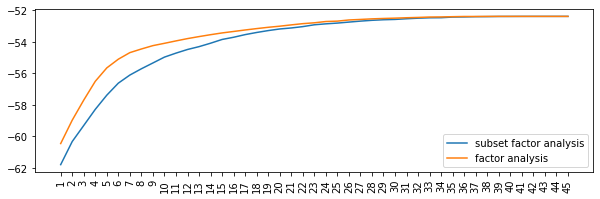

In [ ]:
plt.rcParams["figure.figsize"] = (10,3)
plt.plot(range(1, k_max+1), MLCSS_likelihoods, label='subset factor analysis')
plt.plot(range(1, k_max+1), FA_likelihoods, label='factor analysis')
plt.xticks(range(1, k_max+1), range(1, k_max+1))
plt.xticks(rotation = 90)
plt.legend()

In [ ]:
FA = FactorAnalysis()
FA.compute_MLE_from_data(X, 5)
print(np.mean(np.sort(FA.MLE["D_MLE"])[k:]))

MLCSS = MLColumnSubsetSelection()
MLCSS.compute_MLE_from_data(X, 10, method='swap', model='sf')
print(np.mean(MLCSS.MLE["D_MLE"]))

0.5836328634233462
0.6424115315576037


In [ ]:
from statsmodels.multivariate.factor_rotation import rotate_factors

MLE = FA.MLE.copy()
MLE["W_MLE"] = rotate_factors(FA.MLE["W_MLE"], method='quartimax')[0]

In [ ]:
display_FA_results(MLE)

,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Communality,Uniqueness,Total Var,Mean
0,-0.834,0.209,0.173,-0.109,-0.026,0.782,0.218,0.218,-0.0
1,-0.355,0.374,0.233,-0.577,-0.032,0.654,0.345,0.345,-0.0
2,-0.201,0.832,0.231,-0.131,0.068,0.808,0.192,0.192,0.0
3,-0.414,0.488,0.210,-0.141,0.610,0.845,0.154,0.154,0.0
4,-0.718,-0.010,0.299,-0.132,0.090,0.630,0.370,0.370,-0.0
5,-0.495,0.355,0.215,-0.165,0.706,0.944,0.056,0.056,-0.0
6,-0.220,0.238,0.801,0.011,0.153,0.770,0.229,0.229,0.0
7,-0.257,0.349,0.207,-0.649,0.170,0.680,0.319,0.319,0.0
8,-0.170,0.936,0.067,-0.195,0.107,0.960,0.040,0.040,0.0
9,-0.849,0.230,0.131,-0.185,0.201,0.866,0.134,0.134,-0.0


In [ ]:
display_MLCSS_results(MLCSS.MLE)

#Financial Analysis


In [ ]:
stocks_df = pd.read_csv('stocks_normalized.csv')
stocks = list(stocks_df.columns)[1:]
X = stocks_df.to_numpy()[:, 1:].astype(float)
mu_hat, Sigma_hat = get_moments(X)
p, n = X.shape
X_standardized = diagonal_right_multiply(X - mu_hat, 1/np.sqrt(np.diag(Sigma_hat))) + mu_hat
mu_hat_standardized, Sigma_hat_standardized = get_moments(X_standardized)

In [ ]:
model_selection_with_LRT(X_standardized, 0.05, model='sf', max_iter=100, num_tries=1, sequential=False)

20

In [ ]:
stats.chi2().ppf(0.95, 19)

TypeError: ignored

In [ ]:
CSS = ColumnSubsetSelection()
CSS.select_subset_from_data(X_standardized, k=4, method='swap')
print(CSS.converged)
print(CSS.S)

True
{16, 1, 11, 6}


In [ ]:
MLCSS = MLColumnSubsetSelection()

MLCSS.compute_MLE_from_data(X_standardized, k=4, method='greedy', model='sf')
print(CSS.converged)
print(MLCSS.S)
np.array(stocks)[np.array(list(MLCSS.S))]

True
{1, 14, 6, 15}


array(['MSFT', 'BMY', 'JPM', 'LMT'], dtype='<U4')

In [ ]:
MLCSS_likelihoods = MLCSS_scree_plot_from_data(X_standardized, k_max=10, method='swap', model='sf', plot=False)

In [ ]:
sieves(X_standardized, 0.05, method='swap', model='sf', num_tries=10, max_iter=1000 )

1

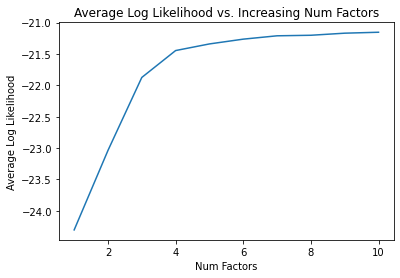

In [ ]:
FA_likelihoods = FA_scree_plot_from_data(X_standardized, k_max=10)

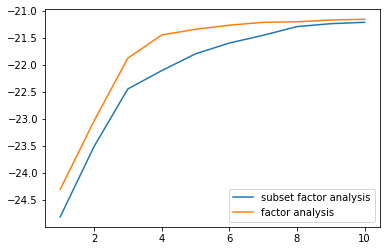

In [ ]:
plt.plot(range(1, 11), MLCSS_likelihoods, label='subset factor analysis')
plt.plot(range(1, 11), FA_likelihoods, label='factor analysis')
plt.legend()